# **Feature Engineering Notebook**

This notebook performs comprehensive feature engineering and data preparation for machine learning models:

- Split data into train and test sets maintaining temporal order.
- Generate technical indicators using ta-lib library to create new features.
- Analyze multicollinearity and correlation between features and remove redundant features.
- Handle missing values by removing NaN entries.
- Scale numerical features and apply label encoding to categorical variables.
- Create target variable for supervised learning tasks.
- Apply Recursive Feature Elimination (RFE) to select most informative features.
- Save processed datasets for model training and evaluation.

---

## **Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import talib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from huggingface_hub import hf_hub_download

## **Get the raw aggregated data**

> **Download it or create this data from the `1.data-exploration.ipynb` file.**

In [2]:
hf_hub_download(
    repo_id="Sierra-Arn/finml-lab-data",
    filename="raw/raw_1h_data.parquet",
    repo_type="dataset",
    local_dir="../data"
)

'../data/raw/raw_1h_data.parquet'

## **Read the raw aggregated data**

In [3]:
data_df = pd.read_parquet("../data/raw/raw_1h_data.parquet")
data_df

,open,high,low,close,volume
datetime,,,,,
2019-09-08 17:00:00,10000.00,10000.00,10000.00,10000.00,0.002
2019-09-08 18:00:00,10000.00,10000.00,10000.00,10000.00,0.000
2019-09-08 19:00:00,10000.00,10357.53,10000.00,10340.12,471.659
2019-09-08 20:00:00,10340.12,10368.64,10334.54,10351.42,583.271
2019-09-08 21:00:00,10351.42,10391.90,10324.77,10391.90,689.759
...,...,...,...,...,...
2024-02-01 08:00:00,42182.30,42246.70,42112.10,42236.00,4634.536
2024-02-01 09:00:00,42236.00,42259.70,42110.70,42141.00,4467.999
2024-02-01 10:00:00,42141.00,42323.60,42100.00,42214.10,6801.445


## **Split data into train and test sets maintaining temporal order**

In [4]:
split_index = int(len(data_df) * 0.8)

train_df = data_df.iloc[:split_index].copy()
test_df = data_df.iloc[split_index:].copy()

## **Preparing training data for feature engineering**

In [5]:
OPEN_PRICES = train_df['open'].values
HIGH_PRICES = train_df['high'].values
LOW_PRICES = train_df['low'].values
CLOSE_PRICES = train_df['close'].values
VOLUME = train_df['volume'].astype(np.double).values

# Different lookback periods provide distinct information
SHORT = 24     # 1 day (24 hours)
MEDIUM = 72    # 3 days (72 hours)  
LONG = 168     # 1 week (168 hours)

CORR_THRESHOLD = 0.5

train_target = train_df.pop('close')

## **Preparing functions for feature engineering**

In [6]:
def create_corr_matrix(df: pd.DataFrame, title='Correlation Matrix'):
    """
    Create and display a correlation matrix heatmap for the given DataFrame.
    
    Args:
        df (pd.DataFrame): Input DataFrame with numerical features
        title (str): Title for the heatmap plot
    """
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Use absolute values to focus on correlation strength regardless of direction
    corr_abs = corr_matrix.abs()
    
    # Create mask to show only lower triangle (avoid duplicate information)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create figure with custom size
    plt.figure(figsize=(25, 8))

    # Plot heatmap with correlation values
    sns.heatmap(
        corr_abs, 
        mask=mask, 
        annot=False, 
        cmap='Reds', 
        square=True, 
        linewidths=0.5, 
        vmin=0, 
        vmax=1
    )
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [7]:
def remove_highly_correlated_features(df: pd.DataFrame, threshold=CORR_THRESHOLD):
    """
    Remove highly correlated features iteratively to reduce multicollinearity.
    
    This function identifies pairs of features with correlation above the threshold
    and removes the feature that has the highest number of correlations exceeding
    the threshold. The process repeats until no highly correlated pairs remain.
    
    Args:
        df (pd.DataFrame): Input DataFrame with numerical features
        threshold (float): Correlation threshold above which features are considered highly correlated
        
    Returns:
        pd.DataFrame: DataFrame with highly correlated features removed
    """
    features_df = df.copy()
    
    iteration = 0
    while True:
        # Calculate absolute correlation matrix
        corr_matrix = features_df.corr().abs()
        
        # Create mask for upper triangle to avoid duplicate pairs
        upper_triangle = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        
        # Find pairs with high correlation
        high_corr_pairs = np.where(corr_matrix.where(upper_triangle) > threshold)
        
        # Break if no highly correlated pairs found
        if len(high_corr_pairs[0]) == 0:
            print(f"Feature removal completed after {iteration} iterations. {len(features_df.columns)} features remaining.")
            break
            
        # Create list of correlated pairs with their correlation values
        corr_list = []
        for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
            col1, col2 = corr_matrix.index[i], corr_matrix.columns[j]
            corr_value = corr_matrix.loc[col1, col2]
            corr_list.append((col1, col2, corr_value))
        
        # Count how many features each feature is highly correlated with
        corr_count = {}
        for col1, col2, _ in corr_list:
            corr_count[col1] = corr_count.get(col1, 0) + 1
            corr_count[col2] = corr_count.get(col2, 0) + 1
        
        # Identify feature with the most high correlations
        feature_to_remove = max(corr_count, key=corr_count.get)
        max_correlations = corr_count[feature_to_remove]
        
        # Remove the feature with highest correlation count
        print(f"Iteration {iteration + 1}: Removing '{feature_to_remove}' (correlated with {max_correlations} features)")
        features_df = features_df.drop(columns=[feature_to_remove])
        
        iteration += 1
    
    return features_df

In [8]:
def filter_low_correlation_features(df):
    """
    Convenience function to remove highly correlated features and visualize the result.
    
    Args:
        df (pd.DataFrame): Input DataFrame with numerical features
        
    Returns:
        pd.DataFrame: DataFrame with highly correlated features removed
    """

    features_df = remove_highly_correlated_features(df)
    create_corr_matrix(features_df)
    
    return features_df

# **Feature engineering**

## **Create features, analyze multicollinearity and correlation between features and remove redundant features**

> **Note:** since some features require values from previous records, certain entries will contain NaN values. `pandas.corr()` automatically handles this by using only the intersecting non-NaN values for correlation calculations. Therefore, we can defer NaN removal until the feature combination stage, after completing correlation analysis.

### **I. Moving average features from the overlap studies category**

In [9]:
def create_moving_averages_indicator_group(df: pd.DataFrame, close_prices=CLOSE_PRICES):
    features_df = df.copy()

    # SMA - Simple Moving Average  
    features_df[f'SMA_{SHORT}'] = talib.SMA(close_prices, timeperiod=SHORT)
    features_df[f'SMA_{MEDIUM}'] = talib.SMA(close_prices, timeperiod=MEDIUM)
    features_df[f'SMA_{LONG}'] = talib.SMA(close_prices, timeperiod=LONG)

    # EMA - Exponential Moving Average
    features_df[f'EMA_{SHORT}'] = talib.EMA(close_prices, timeperiod=SHORT)
    features_df[f'EMA_{MEDIUM}'] = talib.EMA(close_prices, timeperiod=MEDIUM)
    features_df[f'EMA_{LONG}'] = talib.EMA(close_prices, timeperiod=LONG)

    # WMA - Weighted Moving Average
    features_df[f'WMA_{SHORT}'] = talib.WMA(close_prices, timeperiod=SHORT)
    features_df[f'WMA_{MEDIUM}'] = talib.WMA(close_prices, timeperiod=MEDIUM)
    features_df[f'WMA_{LONG}'] = talib.WMA(close_prices, timeperiod=LONG)

    # DEMA - Double Exponential Moving Average
    features_df[f'DEMA_{SHORT}'] = talib.DEMA(close_prices, timeperiod=SHORT)
    features_df[f'DEMA_{MEDIUM}'] = talib.DEMA(close_prices, timeperiod=MEDIUM)
    features_df[f'DEMA_{LONG}'] = talib.DEMA(close_prices, timeperiod=LONG)

    # TEMA - Triple Exponential Moving Average
    features_df[f'TEMA_{SHORT}'] = talib.TEMA(close_prices, timeperiod=SHORT)
    features_df[f'TEMA_{MEDIUM}'] = talib.TEMA(close_prices, timeperiod=MEDIUM)
    features_df[f'TEMA_{LONG}'] = talib.TEMA(close_prices, timeperiod=LONG)

    # TRIMA - Triangular Moving Average
    features_df[f'TRIMA_{SHORT}'] = talib.TRIMA(close_prices, timeperiod=SHORT)
    features_df[f'TRIMA_{MEDIUM}'] = talib.TRIMA(close_prices, timeperiod=MEDIUM)
    features_df[f'TRIMA_{LONG}'] = talib.TRIMA(close_prices, timeperiod=LONG)

    # KAMA - Kaufman Adaptive Moving Average
    features_df[f'KAMA_{SHORT}'] = talib.KAMA(close_prices, timeperiod=SHORT)
    features_df[f'KAMA_{MEDIUM}'] = talib.KAMA(close_prices, timeperiod=MEDIUM)
    features_df[f'KAMA_{LONG}'] = talib.KAMA(close_prices, timeperiod=LONG)

    # MAMA - MESA Adaptive Moving Average
    mama, fama = talib.MAMA(close_prices)
    features_df['MAMA'] = mama
    features_df['MAMA_fama'] = fama

    return features_df

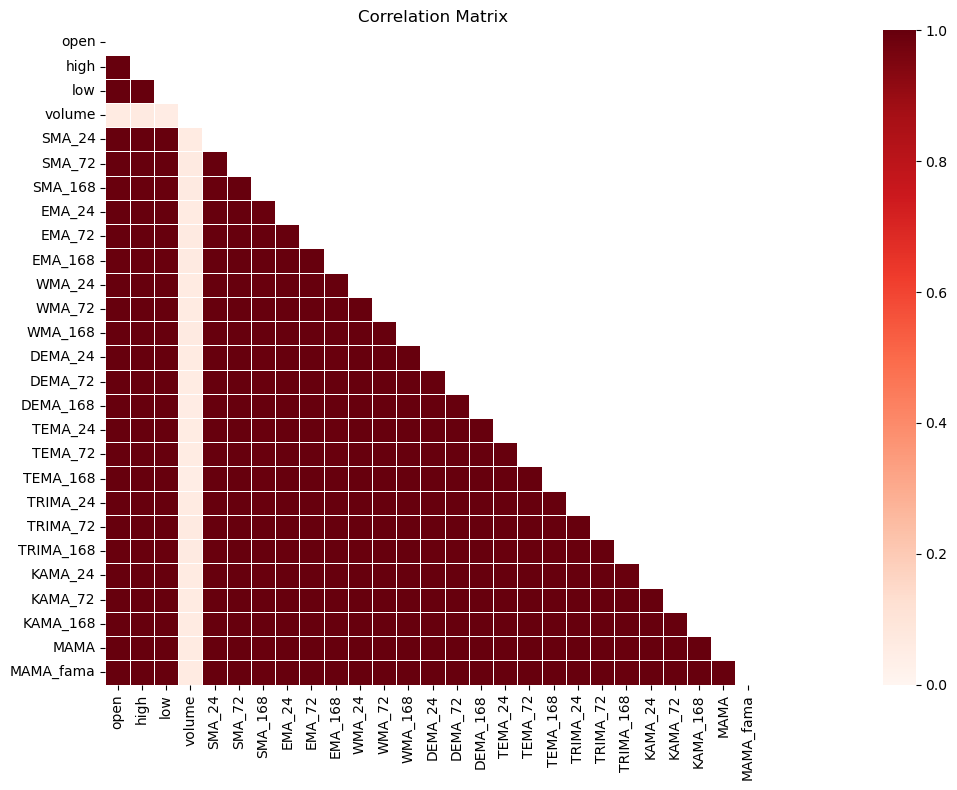

In [10]:
moving_averages_df = create_moving_averages_indicator_group(train_df)
create_corr_matrix(moving_averages_df)

Iteration 1: Removing 'open' (correlated with 25 features)
Iteration 2: Removing 'high' (correlated with 24 features)
Iteration 3: Removing 'low' (correlated with 23 features)
Iteration 4: Removing 'SMA_24' (correlated with 22 features)
Iteration 5: Removing 'SMA_72' (correlated with 21 features)
Iteration 6: Removing 'SMA_168' (correlated with 20 features)
Iteration 7: Removing 'EMA_24' (correlated with 19 features)
Iteration 8: Removing 'EMA_72' (correlated with 18 features)
Iteration 9: Removing 'EMA_168' (correlated with 17 features)
Iteration 10: Removing 'WMA_24' (correlated with 16 features)
Iteration 11: Removing 'WMA_72' (correlated with 15 features)
Iteration 12: Removing 'WMA_168' (correlated with 14 features)
Iteration 13: Removing 'DEMA_24' (correlated with 13 features)
Iteration 14: Removing 'DEMA_72' (correlated with 12 features)
Iteration 15: Removing 'DEMA_168' (correlated with 11 features)
Iteration 16: Removing 'TEMA_24' (correlated with 10 features)
Iteration 17: Re

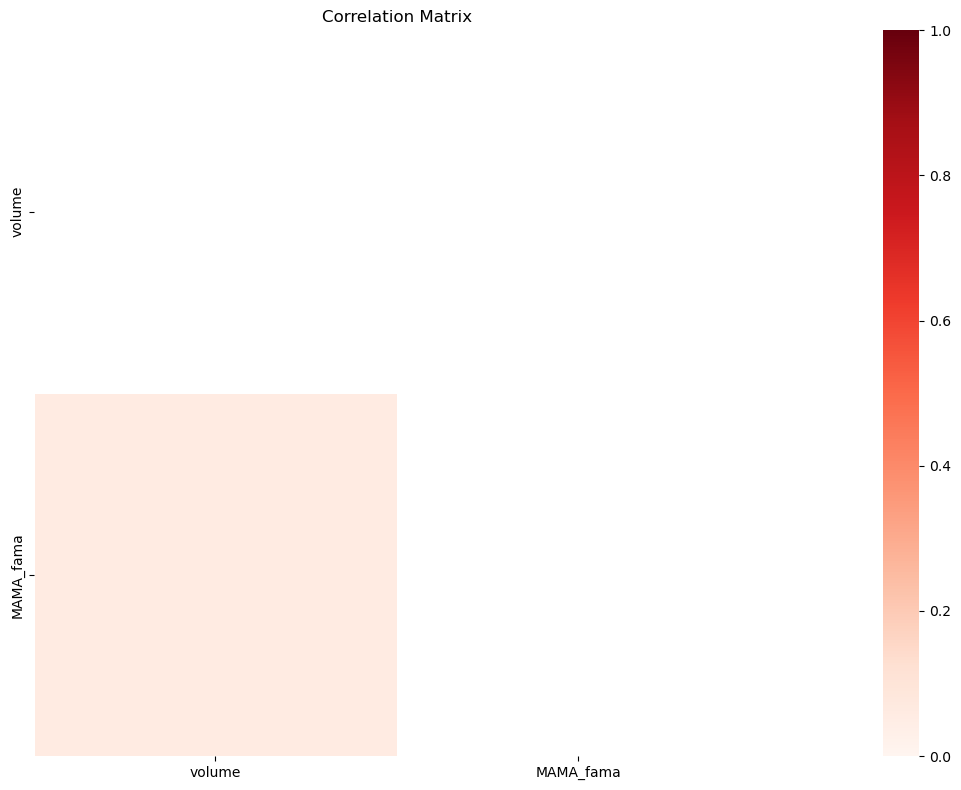

In [11]:
uncorrelated_moving_averages_df = filter_low_correlation_features(moving_averages_df)

### **II. Other features from the overlap studies category**

In [12]:
def create_overlap_studies_indicator_group(df: pd.DataFrame, close_prices=CLOSE_PRICES, high_prices=HIGH_PRICES, low_prices=LOW_PRICES):
    features_df = df.copy()

    # HT_TRENDLINE - Hilbert Transform Trendline
    features_df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close_prices)

    # SAR - Parabolic SAR
    features_df['SAR'] = talib.SAR(high_prices, low_prices, acceleration=0.02, maximum=0.2)

    #  SAREXT - Parabolic SAR Extended
    features_df['SAREXT'] = talib.SAREXT(high_prices, low_prices)

    # MIDPOINT - MidPoint over period
    features_df[f'MIDPOINT_{SHORT}'] = talib.MIDPOINT(close_prices, timeperiod=SHORT)
    features_df[f'MIDPOINT_{MEDIUM}'] = talib.MIDPOINT(close_prices, timeperiod=MEDIUM)
    features_df[f'MIDPOINT_{LONG}'] = talib.MIDPOINT(close_prices, timeperiod=LONG)

    # MIDPRICE - Midpoint Price over period
    features_df[f'MIDPRICE_{SHORT}'] = talib.MIDPRICE(high_prices, low_prices, timeperiod=SHORT)
    features_df[f'MIDPRICE_{MEDIUM}'] = talib.MIDPRICE(high_prices, low_prices, timeperiod=MEDIUM)
    features_df[f'MIDPRICE_{LONG}'] = talib.MIDPRICE(high_prices, low_prices, timeperiod=LONG)

    # BBANDS - Bollinger Bands
    upperband, middleband, lowerband = talib.BBANDS(close_prices, timeperiod=SHORT, nbdevup=2, nbdevdn=2)
    features_df[f'BBANDS_{SHORT}_upper'] = upperband
    features_df[f'BBANDS_{SHORT}_middle'] = middleband
    features_df[f'BBANDS_{SHORT}_lower'] = lowerband

    upperband, middleband, lowerband = talib.BBANDS(close_prices, timeperiod=MEDIUM, nbdevup=2, nbdevdn=2)
    features_df[f'BBANDS_{MEDIUM}_upper'] = upperband
    features_df[f'BBANDS_{MEDIUM}_middle'] = middleband
    features_df[f'BBANDS_{MEDIUM}_lower'] = lowerband

    upperband, middleband, lowerband = talib.BBANDS(close_prices, timeperiod=LONG, nbdevup=2, nbdevdn=2)
    features_df[f'BBANDS_{LONG}_upper'] = upperband
    features_df[f'BBANDS_{LONG}_middle'] = middleband
    features_df[f'BBANDS_{LONG}_lower'] = lowerband

    return features_df

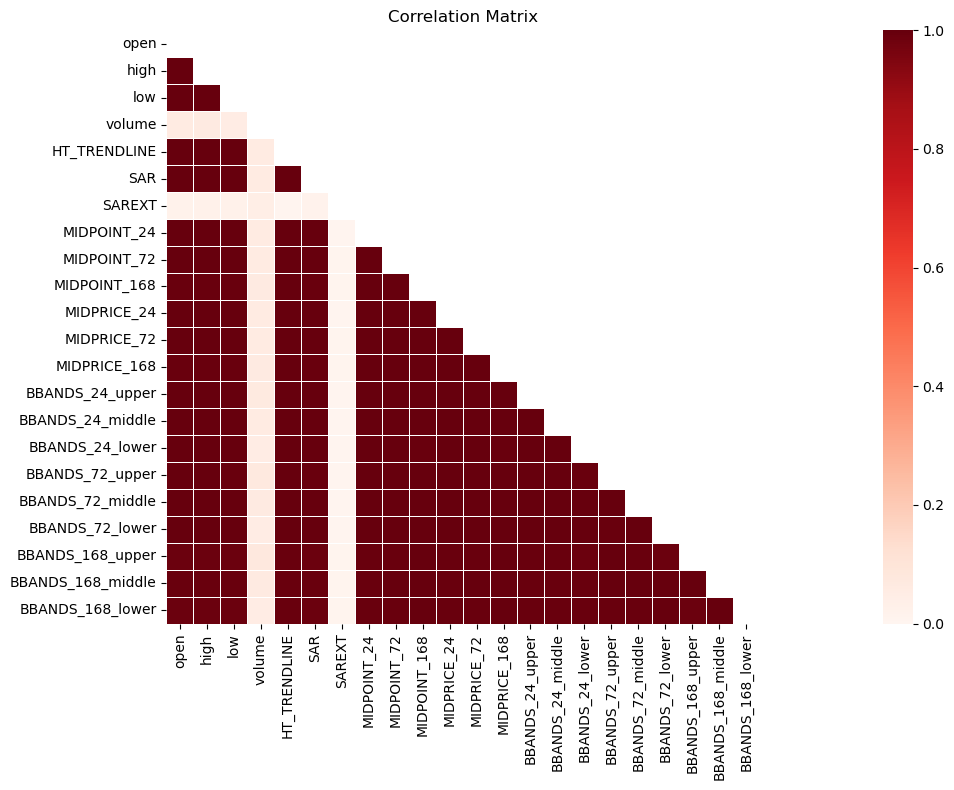

In [13]:
overlap_studies_df = create_overlap_studies_indicator_group(train_df)
create_corr_matrix(overlap_studies_df)

Iteration 1: Removing 'open' (correlated with 19 features)
Iteration 2: Removing 'high' (correlated with 18 features)
Iteration 3: Removing 'low' (correlated with 17 features)
Iteration 4: Removing 'HT_TRENDLINE' (correlated with 16 features)
Iteration 5: Removing 'SAR' (correlated with 15 features)
Iteration 6: Removing 'MIDPOINT_24' (correlated with 14 features)
Iteration 7: Removing 'MIDPOINT_72' (correlated with 13 features)
Iteration 8: Removing 'MIDPOINT_168' (correlated with 12 features)
Iteration 9: Removing 'MIDPRICE_24' (correlated with 11 features)
Iteration 10: Removing 'MIDPRICE_72' (correlated with 10 features)
Iteration 11: Removing 'MIDPRICE_168' (correlated with 9 features)
Iteration 12: Removing 'BBANDS_24_upper' (correlated with 8 features)
Iteration 13: Removing 'BBANDS_24_middle' (correlated with 7 features)
Iteration 14: Removing 'BBANDS_24_lower' (correlated with 6 features)
Iteration 15: Removing 'BBANDS_72_upper' (correlated with 5 features)
Iteration 16: Remov

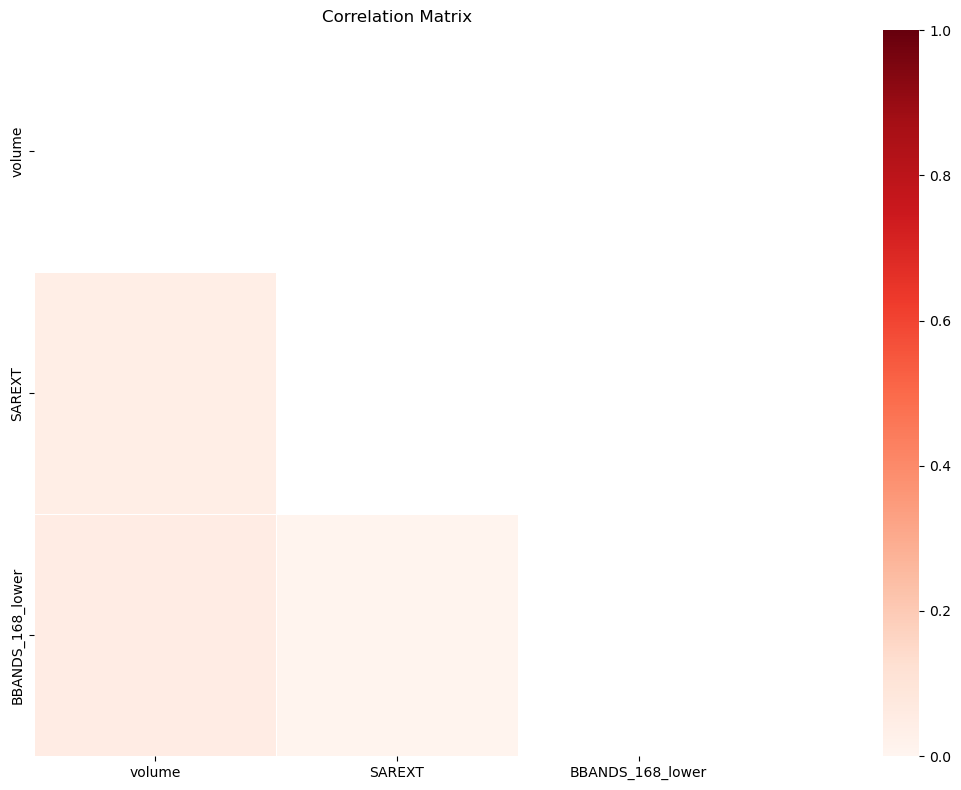

In [14]:
uncorrelated_overlap_studies_df = filter_low_correlation_features(overlap_studies_df)

### **III. Index features from the momentum indicators category**

In [15]:
def create_momentum_index_indicator_group(df: pd.DataFrame, high_prices=HIGH_PRICES, low_prices=LOW_PRICES, close_prices=CLOSE_PRICES, volume=VOLUME):

    features_df = df.copy()

    # ADX - Average Directional Movement Index
    features_df[f'ADX_{SHORT}'] = talib.ADX(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'ADX_{MEDIUM}'] = talib.ADX(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'ADX_{LONG}'] = talib.ADX(high_prices, low_prices, close_prices, timeperiod=LONG)

    # ADXR - Average Directional Movement Index Rating
    features_df[f'ADXR_{SHORT}'] = talib.ADXR(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'ADXR_{MEDIUM}'] = talib.ADXR(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'ADXR_{LONG}'] = talib.ADXR(high_prices, low_prices, close_prices, timeperiod=LONG)

    # CCI - Commodity Channel Index
    features_df[f'CCI_{SHORT}'] = talib.CCI(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'CCI_{MEDIUM}'] = talib.CCI(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'CCI_{LONG}'] = talib.CCI(high_prices, low_prices, close_prices, timeperiod=LONG)

    # DX - Directional Movement Index
    features_df[f'DX_{SHORT}'] = talib.DX(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'DX_{MEDIUM}'] = talib.DX(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'DX_{LONG}'] = talib.DX(high_prices, low_prices, close_prices, timeperiod=LONG)

    # MFI - Money Flow Index
    features_df[f'MFI_{SHORT}'] = talib.MFI(high_prices, low_prices, close_prices, volume, timeperiod=SHORT)
    features_df[f'MFI_{MEDIUM}'] = talib.MFI(high_prices, low_prices, close_prices, volume, timeperiod=MEDIUM)
    features_df[f'MFI_{LONG}'] = talib.MFI(high_prices, low_prices, close_prices, volume, timeperiod=LONG)

    # RSI - Relative Strength Index
    features_df[f'RSI_{SHORT}'] = talib.RSI(close_prices, timeperiod=SHORT)
    features_df[f'RSI_{MEDIUM}'] = talib.RSI(close_prices, timeperiod=MEDIUM)
    features_df[f'RSI_{LONG}'] = talib.RSI(close_prices, timeperiod=LONG)

    # STOCHRSI - Stochastic Relative Strength Index
    fastk_rsi, fastd_rsi = talib.STOCHRSI(
        close_prices, 
        timeperiod=14,
        fastk_period=5, 
        fastd_period=3, 
        fastd_matype=0
    )
    features_df['STOCHRSI_K'] = fastk_rsi
    features_df['STOCHRSI_D'] = fastd_rsi

    return features_df

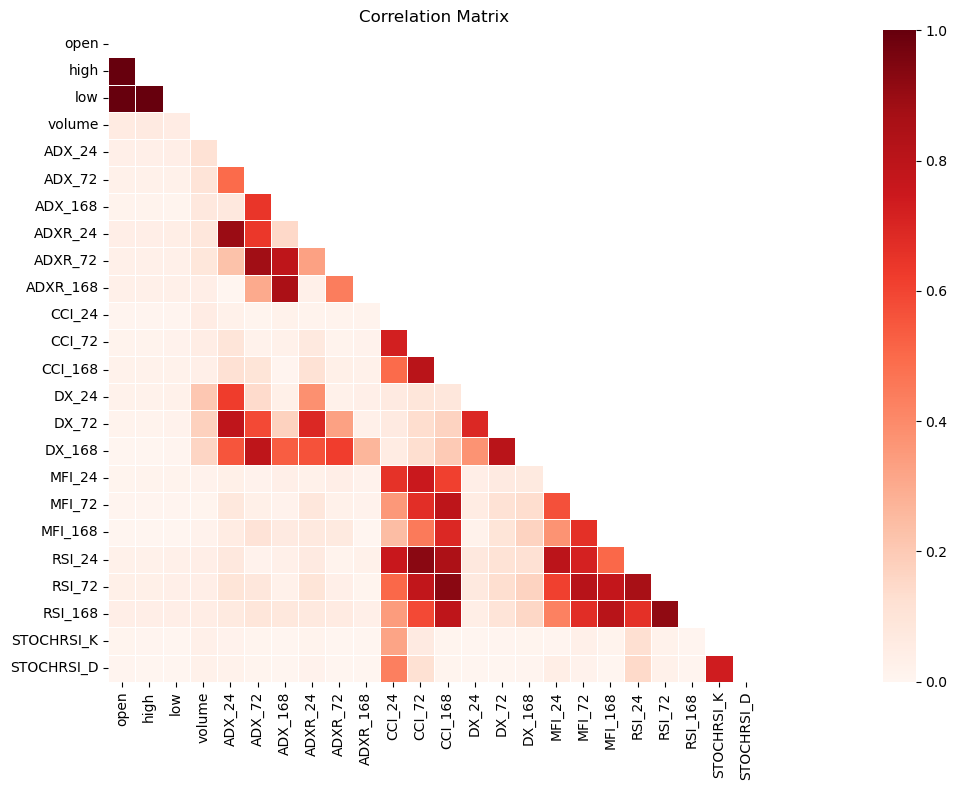

In [16]:
momentum_index_df = create_momentum_index_indicator_group(train_df)
create_corr_matrix(momentum_index_df)

Iteration 1: Removing 'RSI_24' (correlated with 8 features)
Iteration 2: Removing 'RSI_72' (correlated with 7 features)
Iteration 3: Removing 'DX_168' (correlated with 6 features)
Iteration 4: Removing 'CCI_72' (correlated with 5 features)
Iteration 5: Removing 'DX_72' (correlated with 4 features)
Iteration 6: Removing 'CCI_168' (correlated with 4 features)
Iteration 7: Removing 'ADX_72' (correlated with 3 features)
Iteration 8: Removing 'MFI_72' (correlated with 3 features)
Iteration 9: Removing 'open' (correlated with 2 features)
Iteration 10: Removing 'ADX_24' (correlated with 2 features)
Iteration 11: Removing 'ADX_168' (correlated with 2 features)
Iteration 12: Removing 'high' (correlated with 1 features)
Iteration 13: Removing 'CCI_24' (correlated with 1 features)
Iteration 14: Removing 'MFI_168' (correlated with 1 features)
Iteration 15: Removing 'STOCHRSI_K' (correlated with 1 features)
Feature removal completed after 15 iterations. 9 features remaining.


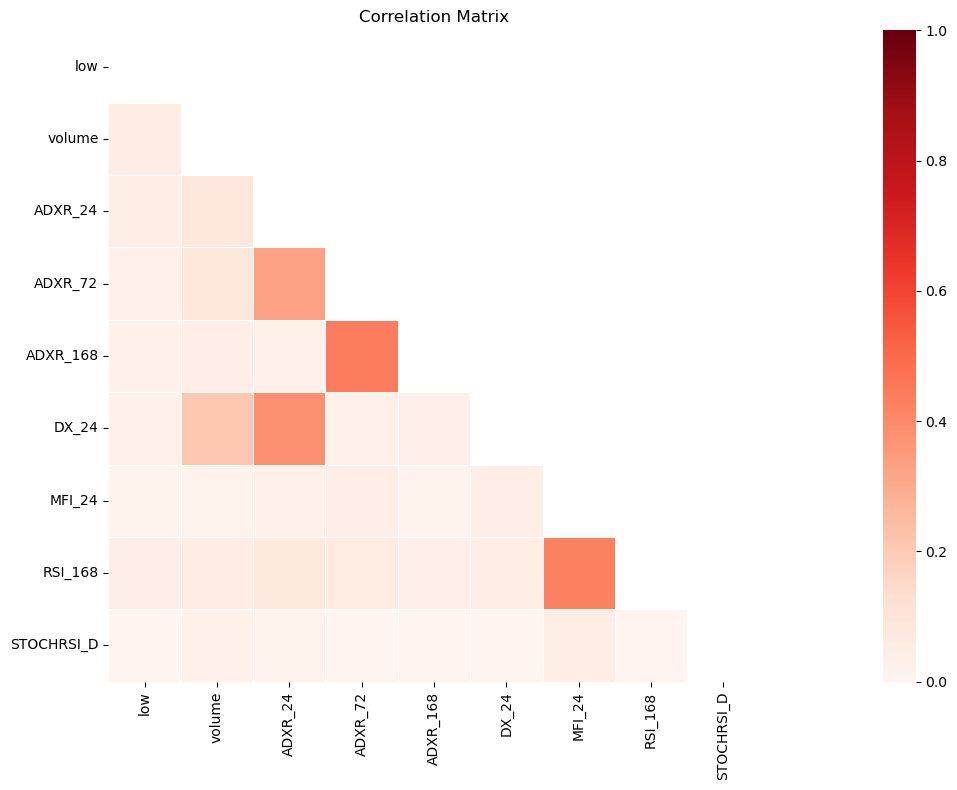

In [17]:
uncorrelated_momentum_index_df = filter_low_correlation_features(momentum_index_df)

### **IV. Oscillator features from the momentum indicators category**

In [18]:
def create_oscillator_indicator_group(df: pd.DataFrame, open_prices=OPEN_PRICES, high_prices=HIGH_PRICES, low_prices=LOW_PRICES, close_prices=CLOSE_PRICES):

    features_df = df.copy()

    # All these "magic numbers" represent historical standards in technical analysis
    
    # APO - Absolute Price Oscillator
    features_df['APO'] = talib.APO(close_prices, fastperiod=12, slowperiod=26, matype=0)

    # AROONOSC - Aroon Oscillator
    features_df['AROONOSC'] = talib.AROONOSC(high_prices, low_prices, timeperiod=14)

    # PPO - Percentage Price Oscillator
    features_df['PPO'] = talib.PPO(close_prices, fastperiod=12, slowperiod=26, matype=0)

    # ULTOSC - Ultimate Oscillator
    features_df['ULTOSC'] = talib.ULTOSC(
        high_prices, 
        low_prices, 
        close_prices,
        timeperiod1=7, 
        timeperiod2=14, 
        timeperiod3=28
    )

    # CMO - Chande Momentum Oscillator
    features_df[f'CMO_{SHORT}'] = talib.CMO(close_prices, timeperiod=SHORT)
    features_df[f'CMO_{MEDIUM}'] = talib.CMO(close_prices, timeperiod=MEDIUM)
    features_df[f'CMO_{LONG}'] = talib.CMO(close_prices, timeperiod=LONG)

    # TRIX - 1-day Rate-Of-Change of a Triple Smooth EMA
    features_df[f'TRIX_{SHORT}'] = talib.TRIX(close_prices, timeperiod=SHORT)
    features_df[f'TRIX_{MEDIUM}'] = talib.TRIX(close_prices, timeperiod=MEDIUM)
    features_df[f'TRIX_{LONG}'] = talib.TRIX(close_prices, timeperiod=LONG)

    # WILLR - Williams' %R
    features_df[f'WILLR_{SHORT}'] = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'WILLR_{MEDIUM}'] = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'WILLR_{LONG}'] = talib.WILLR(high_prices, low_prices, close_prices, timeperiod=LONG)

    # AROON - Aroon
    aroon_down, aroon_up = talib.AROON(high_prices, low_prices, timeperiod=14)
    features_df['AROON_down'] = aroon_down
    features_df['AROON_up'] = aroon_up

    # BOP - Balance Of Power
    features_df['BOP'] = talib.BOP(open_prices, high_prices, low_prices, close_prices)

    # MACD - Moving Average Convergence/Divergence
    macd, macd_signal, macd_hist = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    features_df['MACD'] = macd
    features_df['MACD_signal'] = macd_signal
    features_df['MACD_hist'] = macd_hist

    # STOCH - Stochastic
    slowk, slowd = talib.STOCH(
        high_prices, 
        low_prices, 
        close_prices, 
        fastk_period=5, 
        slowk_period=3, 
        slowk_matype=0,
        slowd_period=3, 
        slowd_matype=0
    )
    features_df['STOCH_K'] = slowk
    features_df['STOCH_D'] = slowd

    # STOCHF - Stochastic Fast
    fastk, fastd = talib.STOCHF(
        high_prices, 
        low_prices, 
        close_prices,
        fastk_period=5, 
        fastd_period=3, 
        fastd_matype=0
    )
    features_df['STOCHF_K'] = fastk
    features_df['STOCHF_D'] = fastd

    return features_df

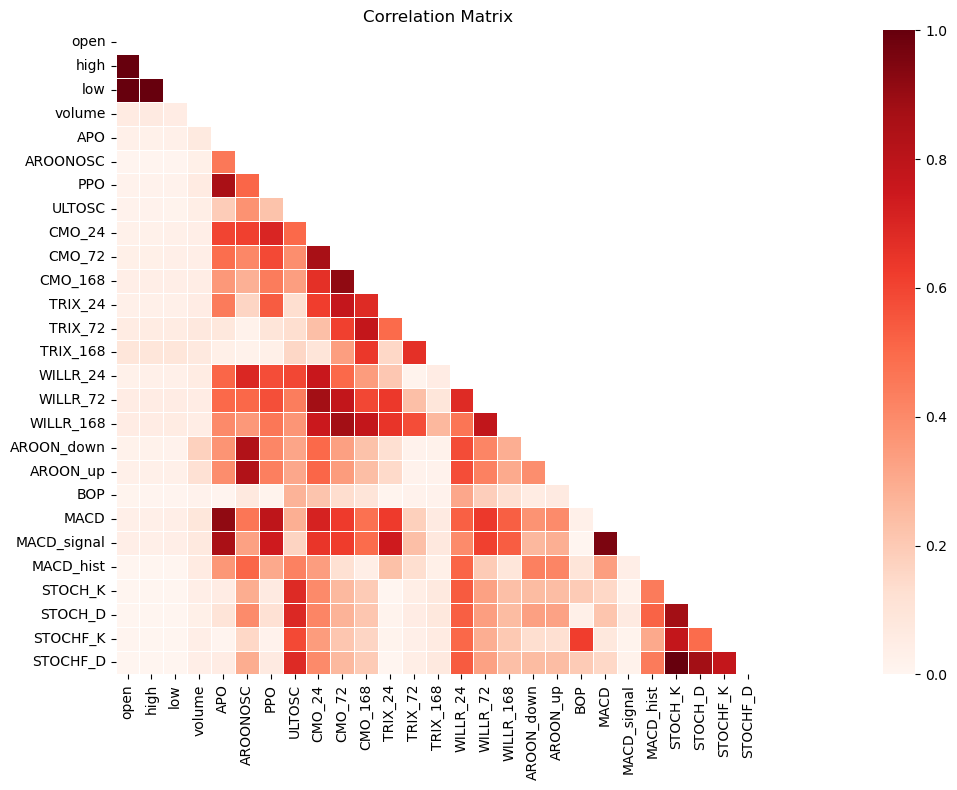

In [19]:
oscillator_df = create_oscillator_indicator_group(train_df)
create_corr_matrix(oscillator_df)

Iteration 1: Removing 'WILLR_24' (correlated with 15 features)
Iteration 2: Removing 'CMO_24' (correlated with 13 features)
Iteration 3: Removing 'WILLR_72' (correlated with 9 features)
Iteration 4: Removing 'CMO_72' (correlated with 7 features)
Iteration 5: Removing 'PPO' (correlated with 5 features)
Iteration 6: Removing 'WILLR_168' (correlated with 5 features)
Iteration 7: Removing 'ULTOSC' (correlated with 4 features)
Iteration 8: Removing 'MACD' (correlated with 3 features)
Iteration 9: Removing 'AROONOSC' (correlated with 3 features)
Iteration 10: Removing 'CMO_168' (correlated with 3 features)
Iteration 11: Removing 'STOCHF_K' (correlated with 3 features)
Iteration 12: Removing 'STOCH_D' (correlated with 3 features)
Iteration 13: Removing 'open' (correlated with 2 features)
Iteration 14: Removing 'MACD_signal' (correlated with 2 features)
Iteration 15: Removing 'high' (correlated with 1 features)
Iteration 16: Removing 'TRIX_72' (correlated with 1 features)
Iteration 17: Removin

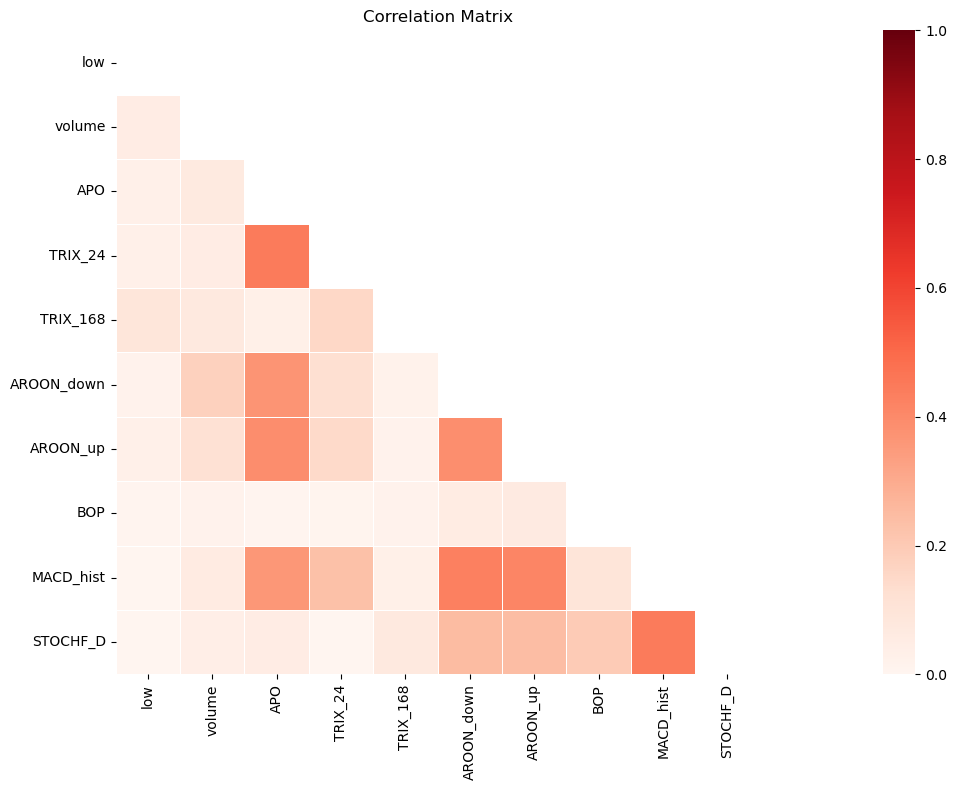

In [20]:
uncorrelated_oscillator_df = filter_low_correlation_features(oscillator_df)

### **V. Indicator features from the momentum indicators category**

In [21]:
def create_momentum_indicators_indicator_group(df: pd.DataFrame, high_prices=HIGH_PRICES, low_prices=LOW_PRICES, close_prices=CLOSE_PRICES):

    features_df = df.copy()

    # MINUS_DI - Minus Directional Indicator
    features_df[f'MINUS_DI_{SHORT}'] = talib.MINUS_DI(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'MINUS_DI_{MEDIUM}'] = talib.MINUS_DI(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'MINUS_DI_{LONG}'] = talib.MINUS_DI(high_prices, low_prices, close_prices, timeperiod=LONG)

    # MINUS_DM - Minus Directional Movement
    features_df[f'MINUS_DM_{SHORT}'] = talib.MINUS_DM(high_prices, low_prices, timeperiod=SHORT)
    features_df[f'MINUS_DM_{MEDIUM}'] = talib.MINUS_DM(high_prices, low_prices, timeperiod=MEDIUM)
    features_df[f'MINUS_DM_{LONG}'] = talib.MINUS_DM(high_prices, low_prices, timeperiod=LONG)

    # MOM - Momentum
    features_df[f'MOM_{SHORT}'] = talib.MOM(close_prices, timeperiod=SHORT)
    features_df[f'MOM_{MEDIUM}'] = talib.MOM(close_prices, timeperiod=MEDIUM)
    features_df[f'MOM_{LONG}'] = talib.MOM(close_prices, timeperiod=LONG)

    # PLUS_DI - Plus Directional Indicator
    features_df[f'PLUS_DI_{SHORT}'] = talib.PLUS_DI(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'PLUS_DI_{MEDIUM}'] = talib.PLUS_DI(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'PLUS_DI_{LONG}'] = talib.PLUS_DI(high_prices, low_prices, close_prices, timeperiod=LONG)

    # PLUS_DM - Plus Directional Movement
    features_df[f'PLUS_DM_{SHORT}'] = talib.PLUS_DM(high_prices, low_prices, timeperiod=SHORT)
    features_df[f'PLUS_DM_{MEDIUM}'] = talib.PLUS_DM(high_prices, low_prices, timeperiod=MEDIUM)
    features_df[f'PLUS_DM_{LONG}'] = talib.PLUS_DM(high_prices, low_prices, timeperiod=LONG)

    # ROC - Rate of change
    features_df[f'ROC_{SHORT}'] = talib.ROC(close_prices, timeperiod=SHORT)
    features_df[f'ROC_{MEDIUM}'] = talib.ROC(close_prices, timeperiod=MEDIUM)
    features_df[f'ROC_{LONG}'] = talib.ROC(close_prices, timeperiod=LONG)

    # ROCP - Rate of change Percentage
    features_df[f'ROCP_{SHORT}'] = talib.ROCP(close_prices, timeperiod=SHORT)
    features_df[f'ROCP_{MEDIUM}'] = talib.ROCP(close_prices, timeperiod=MEDIUM)
    features_df[f'ROCP_{LONG}'] = talib.ROCP(close_prices, timeperiod=LONG)

    # ROCR - Rate of change ratio
    features_df[f'ROCR_{SHORT}'] = talib.ROCR(close_prices, timeperiod=SHORT)
    features_df[f'ROCR_{MEDIUM}'] = talib.ROCR(close_prices, timeperiod=MEDIUM)
    features_df[f'ROCR_{LONG}'] = talib.ROCR(close_prices, timeperiod=LONG)

    # ROCR100 - Rate of change ratio 100 scale
    features_df[f'ROCR100_{SHORT}'] = talib.ROCR100(close_prices, timeperiod=SHORT)
    features_df[f'ROCR100_{MEDIUM}'] = talib.ROCR100(close_prices, timeperiod=MEDIUM)
    features_df[f'ROCR100_{LONG}'] = talib.ROCR100(close_prices, timeperiod=LONG)

    return features_df

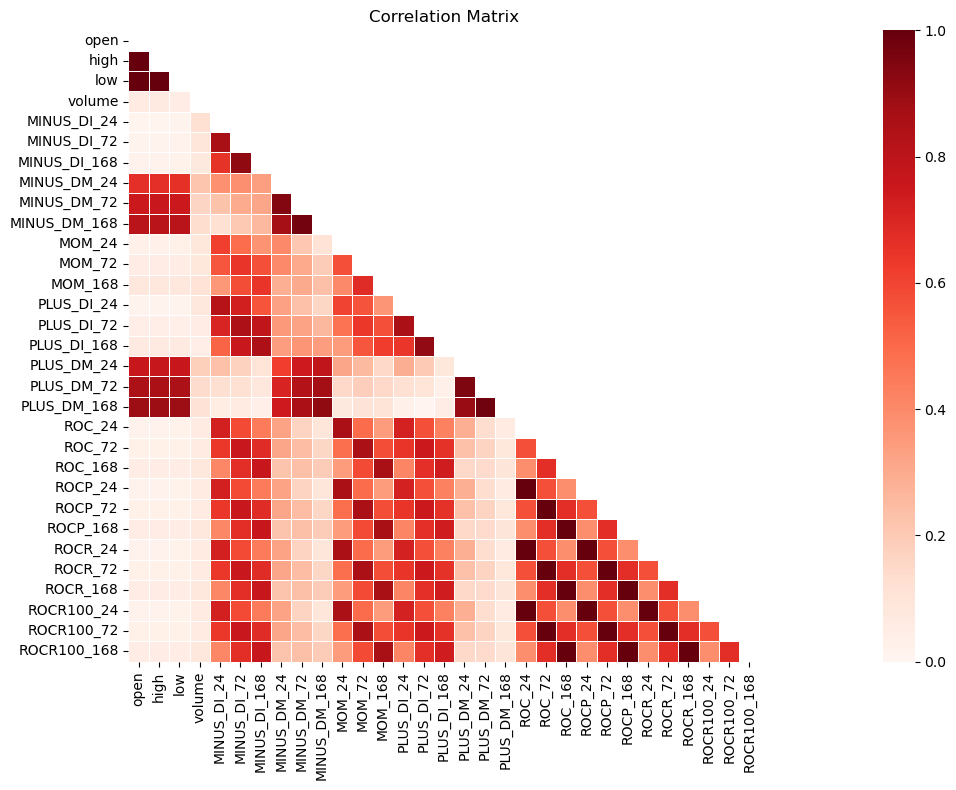

In [22]:
momentum_indicators_df = create_momentum_indicators_indicator_group(train_df)
create_corr_matrix(momentum_indicators_df)

Iteration 1: Removing 'MINUS_DI_72' (correlated with 19 features)
Iteration 2: Removing 'PLUS_DI_72' (correlated with 18 features)
Iteration 3: Removing 'ROC_72' (correlated with 17 features)
Iteration 4: Removing 'ROCP_72' (correlated with 16 features)
Iteration 5: Removing 'ROCR_72' (correlated with 15 features)
Iteration 6: Removing 'ROCR100_72' (correlated with 14 features)
Iteration 7: Removing 'MOM_72' (correlated with 10 features)
Iteration 8: Removing 'open' (correlated with 8 features)
Iteration 9: Removing 'MINUS_DI_24' (correlated with 8 features)
Iteration 10: Removing 'high' (correlated with 7 features)
Iteration 11: Removing 'MINUS_DI_168' (correlated with 7 features)
Iteration 12: Removing 'low' (correlated with 6 features)
Iteration 13: Removing 'PLUS_DI_24' (correlated with 6 features)
Iteration 14: Removing 'MINUS_DM_24' (correlated with 5 features)
Iteration 15: Removing 'MOM_168' (correlated with 5 features)
Iteration 16: Removing 'MINUS_DM_72' (correlated with 4 fe

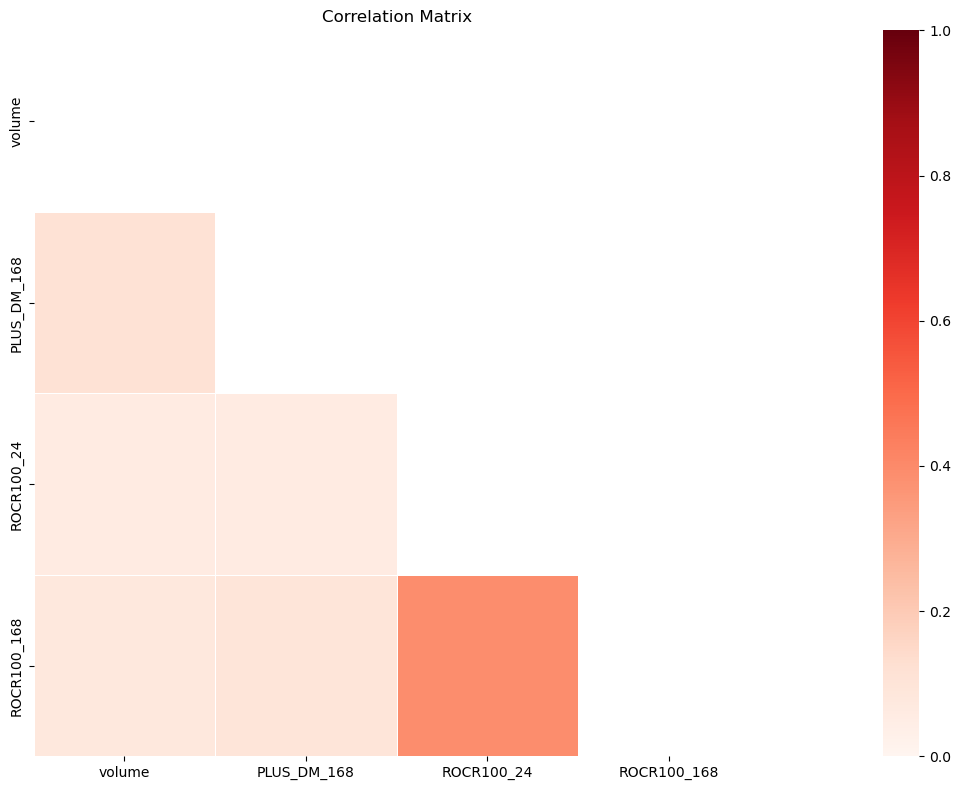

In [23]:
uncorrelated_momentum_indicators_df = filter_low_correlation_features(momentum_indicators_df)

### **VI. Features from the volume and cycle indicators categories**

In [24]:
def create_volume_cycle_indicator_group(df: pd.DataFrame, high_prices=HIGH_PRICES, low_prices=LOW_PRICES, close_prices=CLOSE_PRICES, volume=VOLUME):

    features_df = df.copy()

    # ==================== VOLUME INDICATORS ====================

    # AD - Chaikin A/D Line
    features_df['AD'] = talib.AD(high_prices, low_prices, close_prices, volume)

    # ADOSC - Chaikin A/D Oscillator
    features_df['ADOSC'] = talib.ADOSC(high_prices, low_prices, close_prices, volume, fastperiod=3, slowperiod=10)

    # OBV - On Balance Volume
    features_df['OBV'] = talib.OBV(close_prices, volume)

    # ==================== CYCLE INDICATORS ====================

    # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
    features_df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_prices)

    # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
    features_df['HT_DCPHASE'] = talib.HT_DCPHASE(close_prices)

    # HT_PHASOR - Hilbert Transform - Phasor Components
    inphase, quadrature = talib.HT_PHASOR(close_prices)
    features_df['HT_PHASOR_inphase'] = inphase
    features_df['HT_PHASOR_quadrature'] = quadrature

    # HT_SINE - Hilbert Transform - SineWave
    sine, leadsine = talib.HT_SINE(close_prices)
    features_df['HT_SINE'] = sine
    features_df['HT_SINE_leadsine'] = leadsine

    # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
    features_df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close_prices)

    return features_df

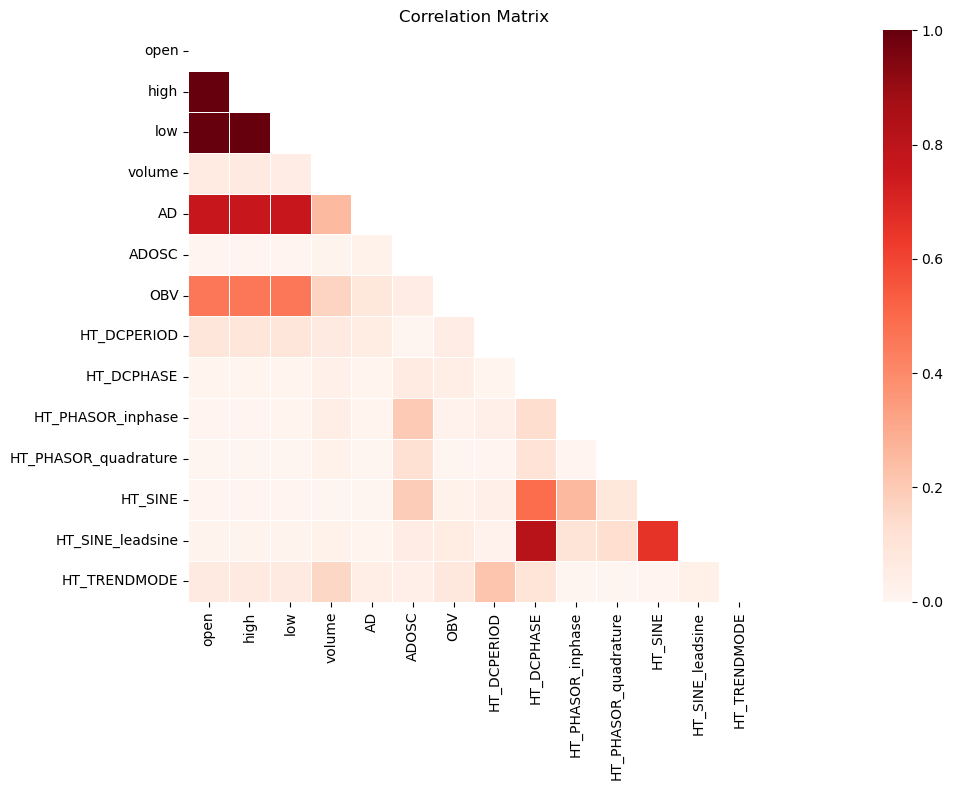

In [25]:
volume_cycle_df = create_volume_cycle_indicator_group(train_df)
create_corr_matrix(volume_cycle_df)

Iteration 1: Removing 'open' (correlated with 3 features)
Iteration 2: Removing 'high' (correlated with 2 features)
Iteration 3: Removing 'HT_SINE_leadsine' (correlated with 2 features)
Iteration 4: Removing 'low' (correlated with 1 features)
Feature removal completed after 4 iterations. 10 features remaining.


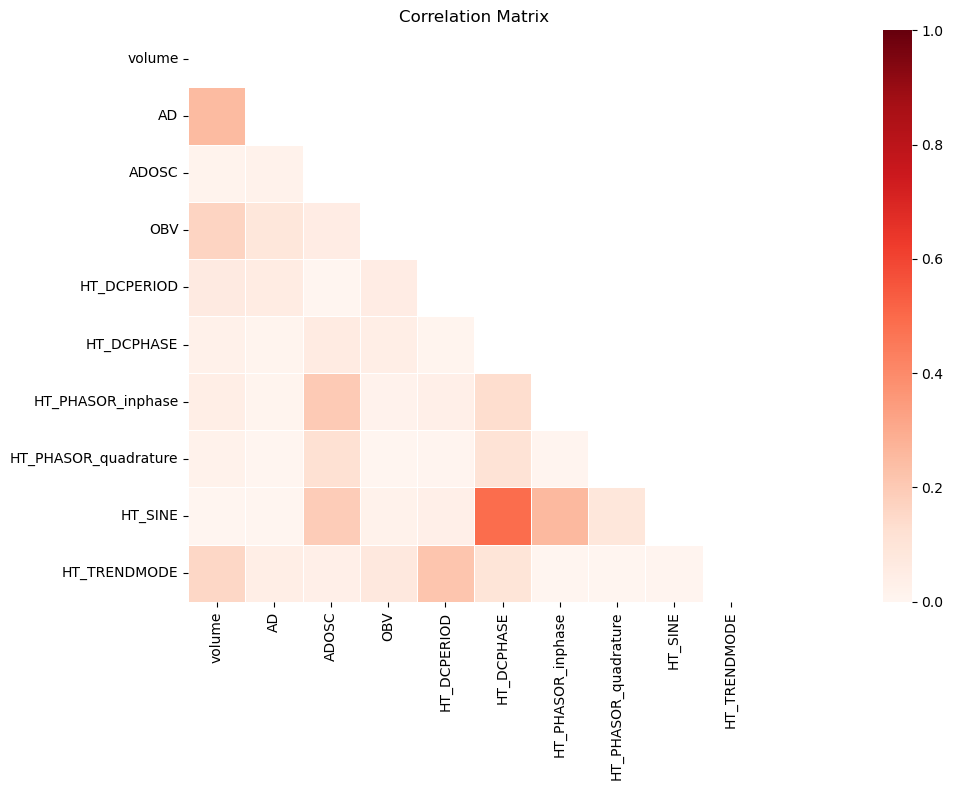

In [26]:
uncorrelated_volume_cycle_df = filter_low_correlation_features(volume_cycle_df)

### **VI. Features from the price transform and volatility indicators categories**

In [27]:
def create_price_volatility_indicator_group(
    df: pd.DataFrame, 
    open_prices=OPEN_PRICES, 
    high_prices=HIGH_PRICES, 
    low_prices=LOW_PRICES, 
    close_prices=CLOSE_PRICES
):

    features_df = df.copy()

    # ==================== PRICE TRANSFORM ====================
    # AVGPRICE - Average Price
    features_df['AVGPRICE'] = talib.AVGPRICE(open_prices, high_prices, low_prices, close_prices)

    # MEDPRICE - Median Price  
    features_df['MEDPRICE'] = talib.MEDPRICE(high_prices, low_prices)

    # TYPPRICE - Typical Price
    features_df['TYPPRICE'] = talib.TYPPRICE(high_prices, low_prices, close_prices)

    # WCLPRICE - Weighted Close Price
    features_df['WCLPRICE'] = talib.WCLPRICE(high_prices, low_prices, close_prices)

    # ==================== VOLATILITY INDICATORS ====================
    # ATR - Average True Range
    features_df[f'ATR_{SHORT}'] = talib.ATR(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'ATR_{MEDIUM}'] = talib.ATR(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'ATR_{LONG}'] = talib.ATR(high_prices, low_prices, close_prices, timeperiod=LONG)

    # NATR - Normalized Average True Range
    features_df[f'NATR_{SHORT}'] = talib.NATR(high_prices, low_prices, close_prices, timeperiod=SHORT)
    features_df[f'NATR_{MEDIUM}'] = talib.NATR(high_prices, low_prices, close_prices, timeperiod=MEDIUM)
    features_df[f'NATR_{LONG}'] = talib.NATR(high_prices, low_prices, close_prices, timeperiod=LONG)

    # TRANGE - True Range
    features_df['TRANGE'] = talib.TRANGE(high_prices, low_prices, close_prices)

    return features_df

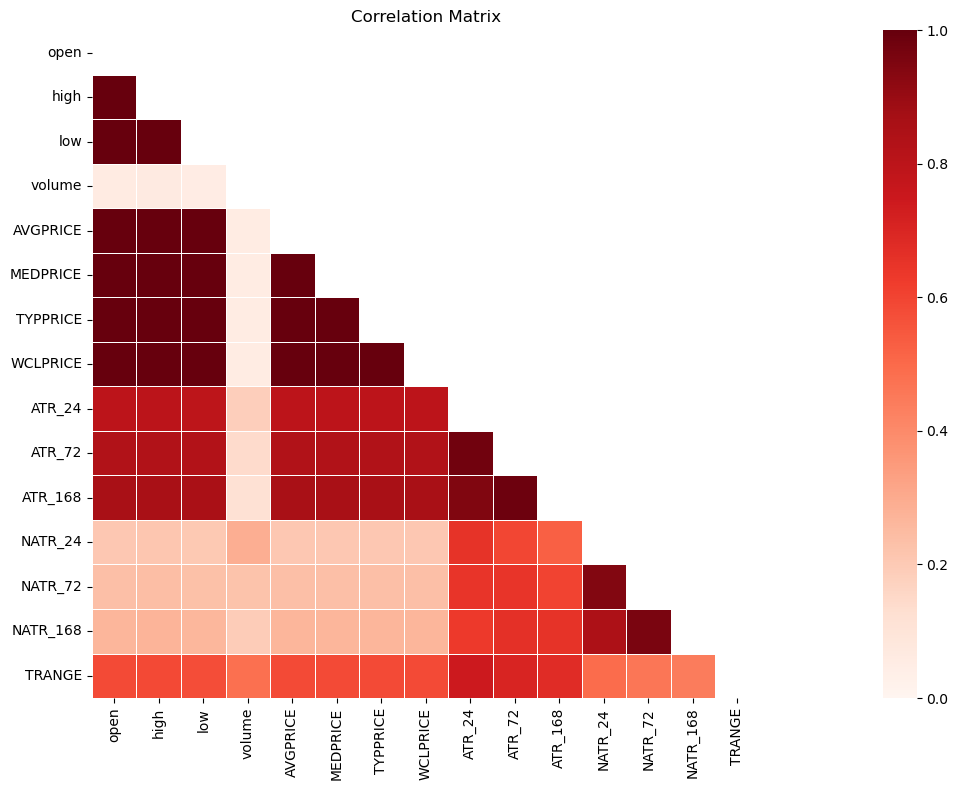

In [28]:
price_volatility_df = create_price_volatility_indicator_group(train_df)
create_corr_matrix(price_volatility_df)

Iteration 1: Removing 'ATR_24' (correlated with 13 features)
Iteration 2: Removing 'ATR_72' (correlated with 12 features)
Iteration 3: Removing 'ATR_168' (correlated with 11 features)
Iteration 4: Removing 'open' (correlated with 7 features)
Iteration 5: Removing 'high' (correlated with 6 features)
Iteration 6: Removing 'low' (correlated with 5 features)
Iteration 7: Removing 'AVGPRICE' (correlated with 4 features)
Iteration 8: Removing 'MEDPRICE' (correlated with 3 features)
Iteration 9: Removing 'TYPPRICE' (correlated with 2 features)
Iteration 10: Removing 'NATR_24' (correlated with 2 features)
Iteration 11: Removing 'WCLPRICE' (correlated with 1 features)
Iteration 12: Removing 'NATR_72' (correlated with 1 features)
Feature removal completed after 12 iterations. 3 features remaining.


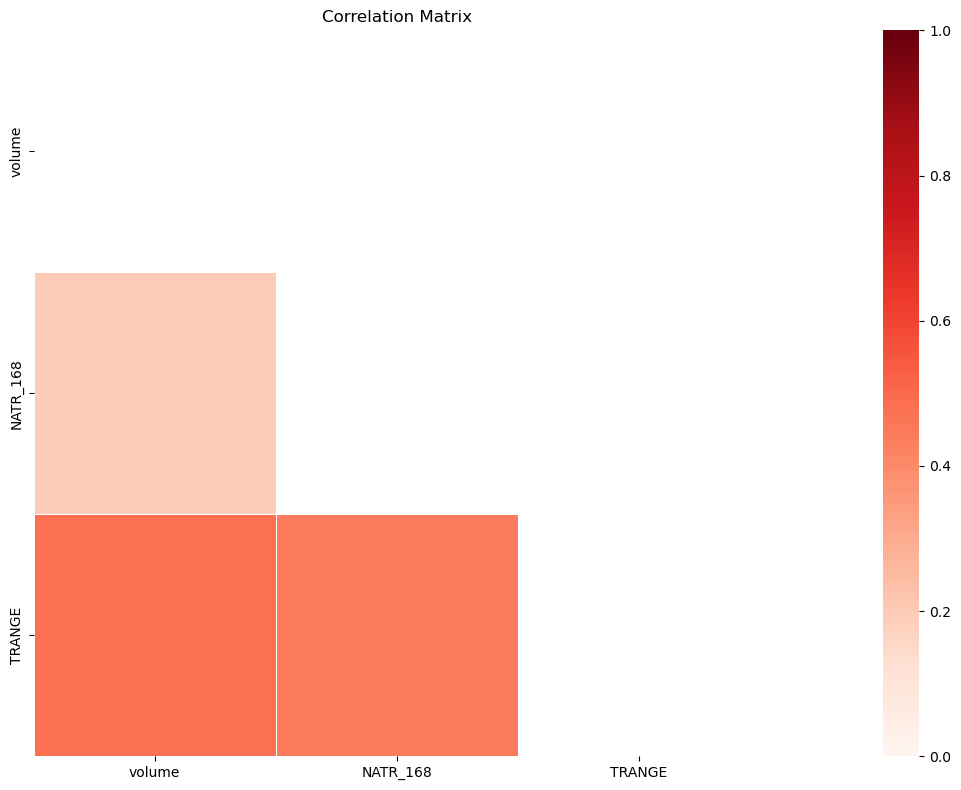

In [29]:
uncorrelated_price_volatility_df = filter_low_correlation_features(price_volatility_df)

### **VII. Features from the pattern recognition category**

In [30]:
def create_pattern_recognition_indicator_group(
    df: pd.DataFrame,
    open_prices=OPEN_PRICES, 
    high_prices=HIGH_PRICES, 
    low_prices=LOW_PRICES, 
    close_prices=CLOSE_PRICES
):

    features_df = df.copy()

    pattern_functions = [
        talib.CDL2CROWS, talib.CDL3BLACKCROWS, talib.CDL3INSIDE, talib.CDL3LINESTRIKE,
        talib.CDL3OUTSIDE, talib.CDL3STARSINSOUTH, talib.CDL3WHITESOLDIERS,
        talib.CDLABANDONEDBABY, talib.CDLADVANCEBLOCK, talib.CDLBELTHOLD,
        talib.CDLBREAKAWAY, talib.CDLCLOSINGMARUBOZU, talib.CDLCONCEALBABYSWALL,
        talib.CDLCOUNTERATTACK, talib.CDLDARKCLOUDCOVER, talib.CDLDOJI,
        talib.CDLDOJISTAR, talib.CDLDRAGONFLYDOJI, talib.CDLENGULFING,
        talib.CDLEVENINGDOJISTAR, talib.CDLEVENINGSTAR, talib.CDLGAPSIDESIDEWHITE,
        talib.CDLGRAVESTONEDOJI, talib.CDLHAMMER, talib.CDLHANGINGMAN,
        talib.CDLHARAMI, talib.CDLHARAMICROSS, talib.CDLHIGHWAVE,
        talib.CDLHIKKAKE, talib.CDLHIKKAKEMOD, talib.CDLHOMINGPIGEON,
        talib.CDLIDENTICAL3CROWS, talib.CDLINNECK, talib.CDLINVERTEDHAMMER,
        talib.CDLKICKING, talib.CDLKICKINGBYLENGTH, talib.CDLLADDERBOTTOM,
        talib.CDLLONGLEGGEDDOJI, talib.CDLLONGLINE, talib.CDLMARUBOZU,
        talib.CDLMATCHINGLOW, talib.CDLMATHOLD, talib.CDLMORNINGDOJISTAR,
        talib.CDLMORNINGSTAR, talib.CDLONNECK, talib.CDLPIERCING,
        talib.CDLRICKSHAWMAN, talib.CDLRISEFALL3METHODS, talib.CDLSEPARATINGLINES,
        talib.CDLSHOOTINGSTAR, talib.CDLSHORTLINE, talib.CDLSPINNINGTOP,
        talib.CDLSTALLEDPATTERN, talib.CDLSTICKSANDWICH, talib.CDLTAKURI,
        talib.CDLTASUKIGAP, talib.CDLTHRUSTING, talib.CDLTRISTAR,
        talib.CDLUNIQUE3RIVER, talib.CDLUPSIDEGAP2CROWS, talib.CDLXSIDEGAP3METHODS
    ]

    pattern_names = [
        'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE',
        'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS',
        'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD',
        'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL',
        'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI',
        'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING',
        'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE',
        'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN',
        'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE',
        'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON',
        'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER',
        'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM',
        'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU',
        'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR',
        'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING',
        'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES',
        'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP',
        'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI',
        'CDLTASUKIGAP', 'CDLTHRUSTING', 'CDLTRISTAR',
        'CDLUNIQUE3RIVER', 'CDLUPSIDEGAP2CROWS', 'CDLXSIDEGAP3METHODS'
    ]

    for func, name in zip(pattern_functions, pattern_names):
        try:
            features_df[name] = func(open_prices, high_prices, low_prices, close_prices)
        except Exception as e:
            print(f"Error creating {name}: {e}")

    return features_df

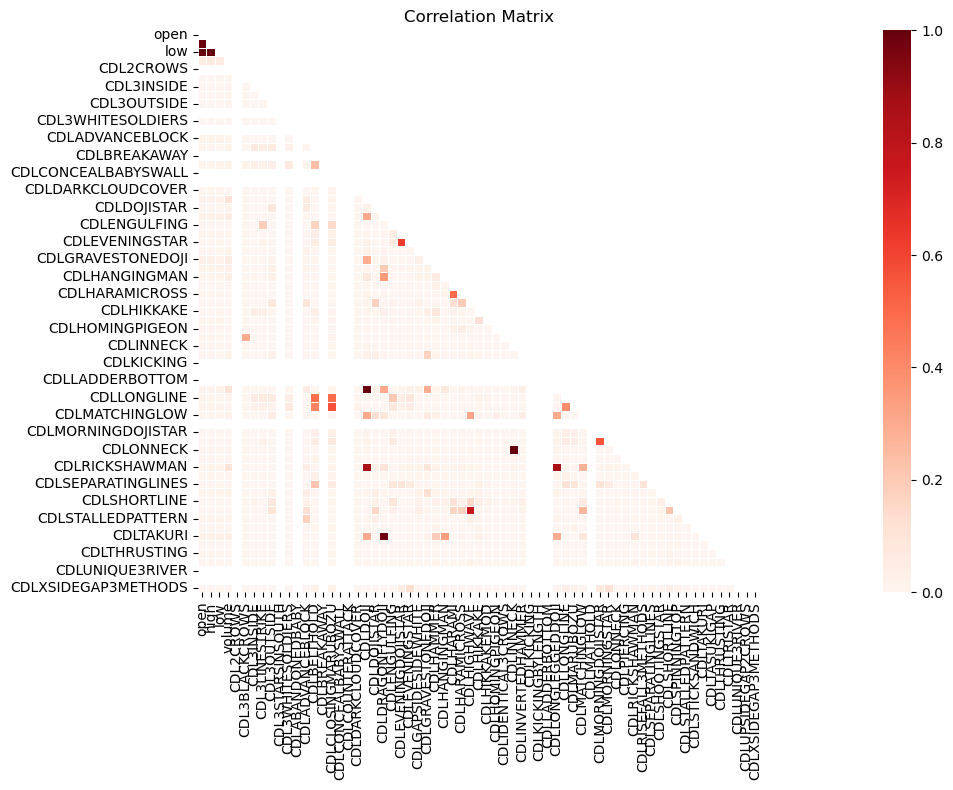

In [31]:
pattern_recognition_df = create_pattern_recognition_indicator_group(train_df)
create_corr_matrix(pattern_recognition_df)

#### **Note**

Upon examining the generated features (e.g., using Microsoft's Data Wrangler), it becomes apparent that many features contain a high proportion of zero values. To address this, we will remove features where the percentage of zero values exceeds a predefined `threshold`, as these features may not contribute meaningful information to the model and could introduce noise.

In [32]:
pattern_recognition_df

,open,high,low,volume,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,CDL3LINESTRIKE,CDL3OUTSIDE,CDL3STARSINSOUTH,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-08 17:00:00,10000.00,10000.00,10000.00,0.002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-08 18:00:00,10000.00,10000.00,10000.00,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-08 19:00:00,10000.00,10357.53,10000.00,471.659,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-08 20:00:00,10340.12,10368.64,10334.54,583.271,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-09-08 21:00:00,10351.42,10391.90,10324.77,689.759,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,24968.90,25067.30,24908.40,17158.018,0,0,0,0,0,0,...,100,0,0,0,0,0,0,0,0,0
2023-03-17 00:00:00,24990.50,24990.50,24875.30,15107.275,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-17 01:00:00,24904.70,25739.80,24900.10,86181.415,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
def clean_sparse_patterns(df: pd.DataFrame, threshold=0.90):
    """
    Remove features with excessive zero values that may not contribute meaningful information.
    
    Args:
        df (pd.DataFrame): Input DataFrame with numerical features
        threshold (float): Threshold for zero ratio above which features are considered sparse
                          (default: 0.90 = 90% zeros)
        
    Returns:
        pd.DataFrame: DataFrame with sparse features removed
    """
    # Calculate the ratio of zero values for each feature
    zero_ratios = (df == 0).mean()
    
    # Identify sparse patterns exceeding the threshold
    sparse_mask = zero_ratios > threshold
    sparse_patterns = zero_ratios[sparse_mask].index.tolist()
    
    # Remove sparse features
    df_clean = df.drop(columns=sparse_patterns)
    
    # Display statistics about feature removal
    print(f"Total features: {len(df.columns)}")
    print(f"Removed sparse features (> {threshold*100}% zeros): {len(sparse_patterns)}")
    print(f"Remaining useful features: {len(df_clean.columns)}")
    
    return df_clean

In [34]:
filtered_pattern_recognition_df = clean_sparse_patterns(pattern_recognition_df)
filtered_pattern_recognition_df

Total features: 65
Removed sparse features (> 90.0% zeros): 52
Remaining useful features: 13


,open,high,low,volume,CDLBELTHOLD,CDLDOJI,CDLHIGHWAVE,CDLHIKKAKE,CDLLONGLEGGEDDOJI,CDLLONGLINE,CDLRICKSHAWMAN,CDLSHORTLINE,CDLSPINNINGTOP
datetime,,,,,,,,,,,,,
2019-09-08 17:00:00,10000.00,10000.00,10000.00,0.002,0,0,0,0,0,0,0,0,0
2019-09-08 18:00:00,10000.00,10000.00,10000.00,0.000,0,0,0,0,0,0,0,0,0
2019-09-08 19:00:00,10000.00,10357.53,10000.00,471.659,0,0,0,0,0,0,0,0,0
2019-09-08 20:00:00,10340.12,10368.64,10334.54,583.271,0,0,0,0,0,0,0,0,0
2019-09-08 21:00:00,10351.42,10391.90,10324.77,689.759,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,24968.90,25067.30,24908.40,17158.018,0,100,100,-100,100,0,100,100,100
2023-03-17 00:00:00,24990.50,24990.50,24875.30,15107.275,0,0,0,0,0,0,0,-100,0
2023-03-17 01:00:00,24904.70,25739.80,24900.10,86181.415,100,0,0,0,0,0,0,0,0


Iteration 1: Removing 'open' (correlated with 2 features)
Iteration 2: Removing 'CDLDOJI' (correlated with 2 features)
Iteration 3: Removing 'high' (correlated with 1 features)
Iteration 4: Removing 'CDLHIGHWAVE' (correlated with 1 features)
Iteration 5: Removing 'CDLLONGLEGGEDDOJI' (correlated with 1 features)
Feature removal completed after 5 iterations. 8 features remaining.


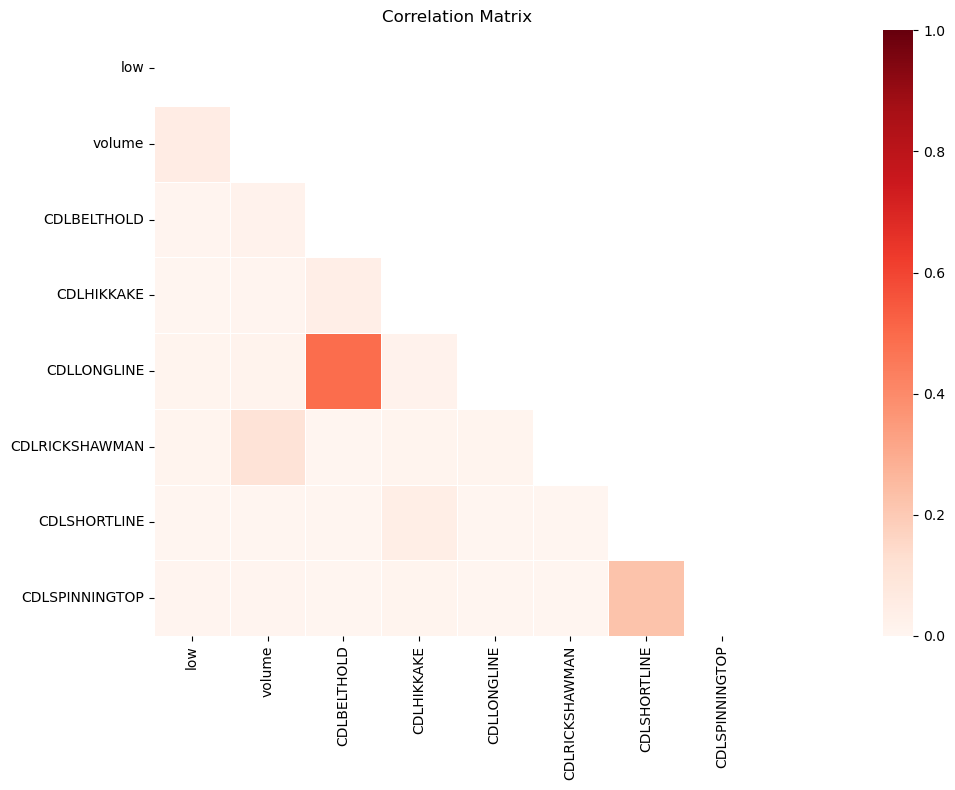

In [35]:
uncorrelated_filtered_pattern_recognition_df = filter_low_correlation_features(filtered_pattern_recognition_df)

### **VIII. Features from the datetime index**

In [36]:
def create_time_recognition_indicator_group(df: pd.DataFrame):
    features_df = df.copy()

    features_df['hour'] = features_df.index.hour
    features_df['day'] = features_df.index.day
    features_df['month'] = features_df.index.month
    features_df['dayofweek'] = features_df.index.dayofweek
    features_df['dayofyear'] = features_df.index.dayofyear

    features_df["candles_since_start"] = (features_df.index - features_df.index[0]).total_seconds() / (60 * 60) # перевод в часовые свечи

    features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
    features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)

    features_df['day_sin'] = np.sin(2 * np.pi * features_df['day'] / 31)
    features_df['day_cos'] = np.cos(2 * np.pi * features_df['day'] / 31)

    features_df['month_sin'] = np.sin(2 * np.pi * features_df['month'] / 12)
    features_df['month_cos'] = np.cos(2 * np.pi * features_df['month'] / 12)

    features_df['dayofweek_sin'] = np.sin(2 * np.pi * features_df['dayofweek'] / 7)
    features_df['dayofweek_cos'] = np.cos(2 * np.pi * features_df['dayofweek'] / 7)

    features_df['dayofyear_sin'] = np.sin(2 * np.pi * features_df['dayofyear'] / 365.25)
    features_df['dayofyear_cos'] = np.cos(2 * np.pi * features_df['dayofyear'] / 365.25)

    return features_df

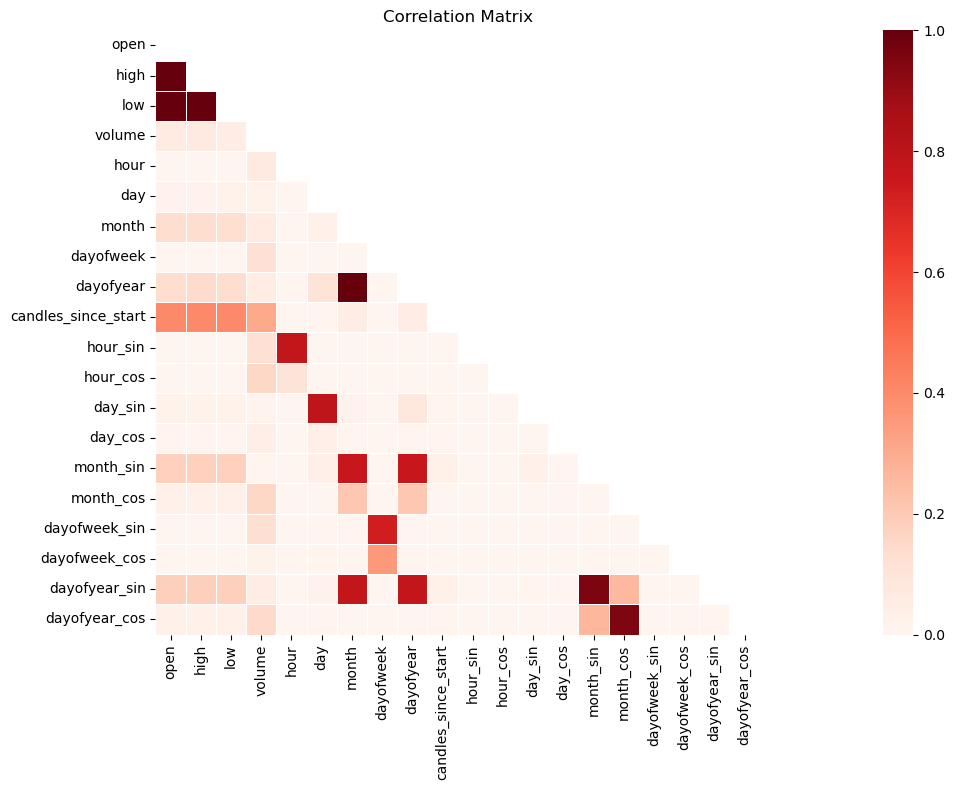

In [37]:
time_recognition_df = create_time_recognition_indicator_group(train_df)
create_corr_matrix(time_recognition_df)

Iteration 1: Removing 'month' (correlated with 3 features)
Iteration 2: Removing 'open' (correlated with 2 features)
Iteration 3: Removing 'dayofyear' (correlated with 2 features)
Iteration 4: Removing 'high' (correlated with 1 features)
Iteration 5: Removing 'hour' (correlated with 1 features)
Iteration 6: Removing 'day' (correlated with 1 features)
Iteration 7: Removing 'dayofweek' (correlated with 1 features)
Iteration 8: Removing 'month_sin' (correlated with 1 features)
Iteration 9: Removing 'month_cos' (correlated with 1 features)
Feature removal completed after 9 iterations. 11 features remaining.


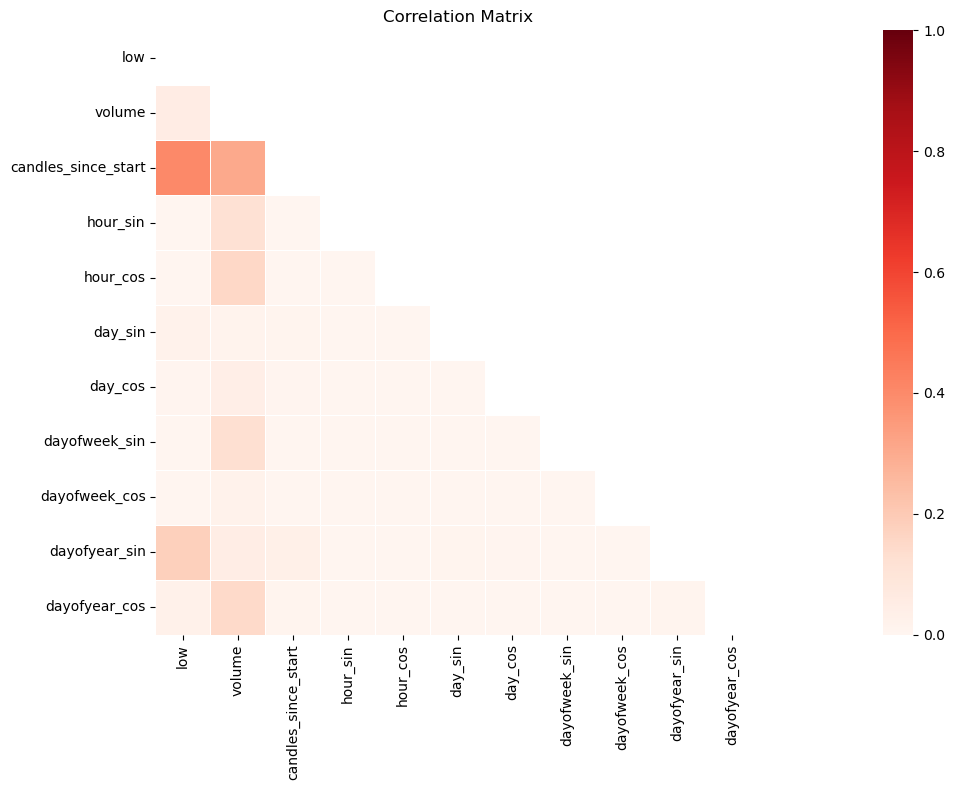

In [38]:
uncorrelated_time_recognition_df = filter_low_correlation_features(time_recognition_df)

### **IX. Feature combination stage**

In [39]:
def combine_unique_feature_dfs(*dataframes: pd.DataFrame) -> pd.DataFrame:
    """
    Combine multiple DataFrames by merging their columns while automatically removing duplicates.
    
    Args:
        *dataframes (pd.DataFrame): Variable number of DataFrame arguments to combine
        
    Returns:
        pd.DataFrame: Combined DataFrame with unique columns only
    """
    
    # Collect all columns with their source DataFrame index
    all_dfs = list(dataframes)
    all_columns = []
    
    for i, df in enumerate(all_dfs):
        all_columns.extend([(col, i) for col in df.columns])
    
    # Remove duplicates by keeping only the first occurrence
    seen_columns = set()
    unique_columns = []
    
    for col, df_idx in all_columns:
        if col not in seen_columns:
            seen_columns.add(col)
            unique_columns.append((col, df_idx))
    
    # Build final DataFrame with unique columns
    final_data = {}
    for col, df_idx in unique_columns:
        final_data[col] = dataframes[df_idx][col]
    
    return pd.DataFrame(final_data)

In [40]:
combined_features_df = combine_unique_feature_dfs(
    uncorrelated_moving_averages_df,
    uncorrelated_overlap_studies_df,
    uncorrelated_momentum_index_df,
    uncorrelated_oscillator_df,
    uncorrelated_momentum_indicators_df,
    uncorrelated_volume_cycle_df,
    uncorrelated_volume_cycle_df,
    uncorrelated_filtered_pattern_recognition_df,
    uncorrelated_time_recognition_df
)

In [41]:
combined_features_df

,volume,MAMA_fama,SAREXT,BBANDS_168_lower,low,ADXR_24,ADXR_72,ADXR_168,DX_24,MFI_24,...,CDLSPINNINGTOP,candles_since_start,hour_sin,hour_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-08 17:00:00,0.002,NaN,NaN,NaN,10000.00,NaN,NaN,NaN,NaN,NaN,...,0,0.0,-0.965926,-2.588190e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 18:00:00,0.000,NaN,-10000.000000,NaN,10000.00,NaN,NaN,NaN,NaN,NaN,...,0,1.0,-1.000000,-1.836970e-16,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 19:00:00,471.659,NaN,10000.000000,NaN,10000.00,NaN,NaN,NaN,NaN,NaN,...,0,2.0,-0.965926,2.588190e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 20:00:00,583.271,NaN,10000.000000,NaN,10334.54,NaN,NaN,NaN,NaN,NaN,...,0,3.0,-0.866025,5.000000e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 21:00:00,689.759,NaN,10000.000000,NaN,10324.77,NaN,NaN,NaN,NaN,NaN,...,0,4.0,-0.707107,7.071068e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,17158.018,24776.126515,24460.408648,18313.798495,24908.40,18.303202,24.647746,14.036837,21.062621,61.281274,...,100,30846.0,-0.258819,9.659258e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946
2023-03-17 00:00:00,15107.275,24808.299059,24502.858129,18344.178781,24875.30,17.991220,24.672446,14.091430,19.649624,62.057177,...,0,30847.0,0.000000,1.000000e+00,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376
2023-03-17 01:00:00,86181.415,24811.648979,24542.760641,18368.782631,24900.10,18.029674,24.742696,14.156044,37.014849,65.348646,...,0,30848.0,0.258819,9.659258e-01,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376


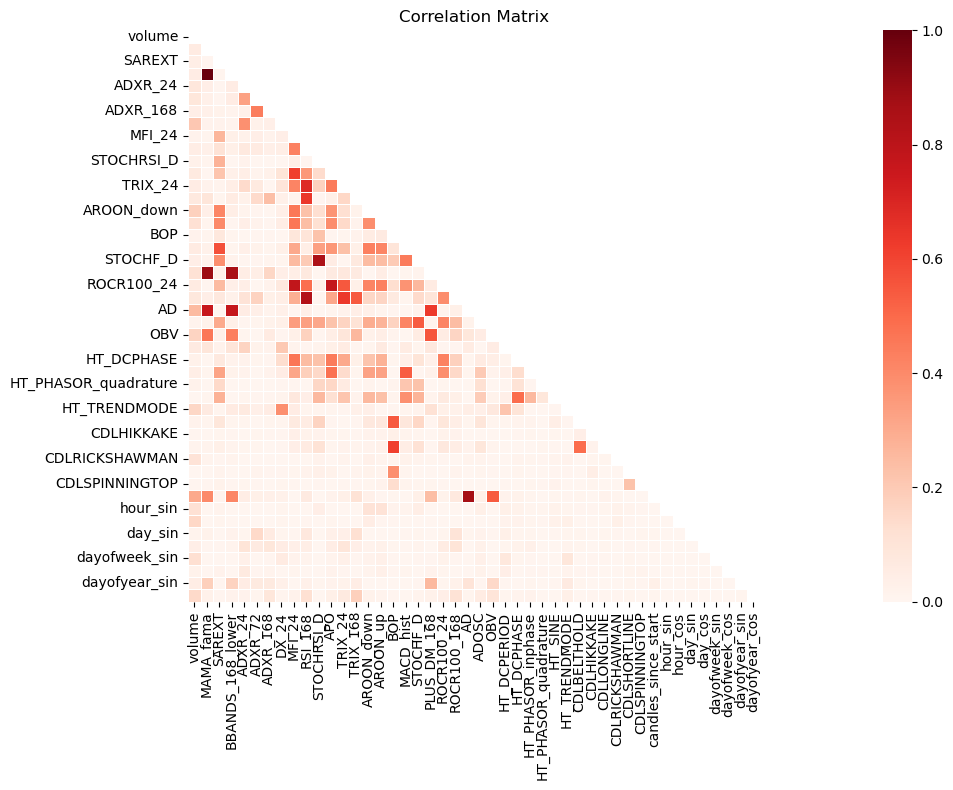

In [42]:
combined_features_df.pop("low")
create_corr_matrix(combined_features_df)

Iteration 1: Removing 'PLUS_DM_168' (correlated with 4 features)
Iteration 2: Removing 'AD' (correlated with 3 features)
Iteration 3: Removing 'ROCR100_24' (correlated with 3 features)
Iteration 4: Removing 'RSI_168' (correlated with 3 features)
Iteration 5: Removing 'MACD_hist' (correlated with 2 features)
Iteration 6: Removing 'STOCHF_D' (correlated with 2 features)
Iteration 7: Removing 'ROCR100_168' (correlated with 2 features)
Iteration 8: Removing 'BOP' (correlated with 2 features)
Iteration 9: Removing 'MAMA_fama' (correlated with 1 features)
Iteration 10: Removing 'MFI_24' (correlated with 1 features)
Iteration 11: Removing 'OBV' (correlated with 1 features)
Feature removal completed after 11 iterations. 35 features remaining.


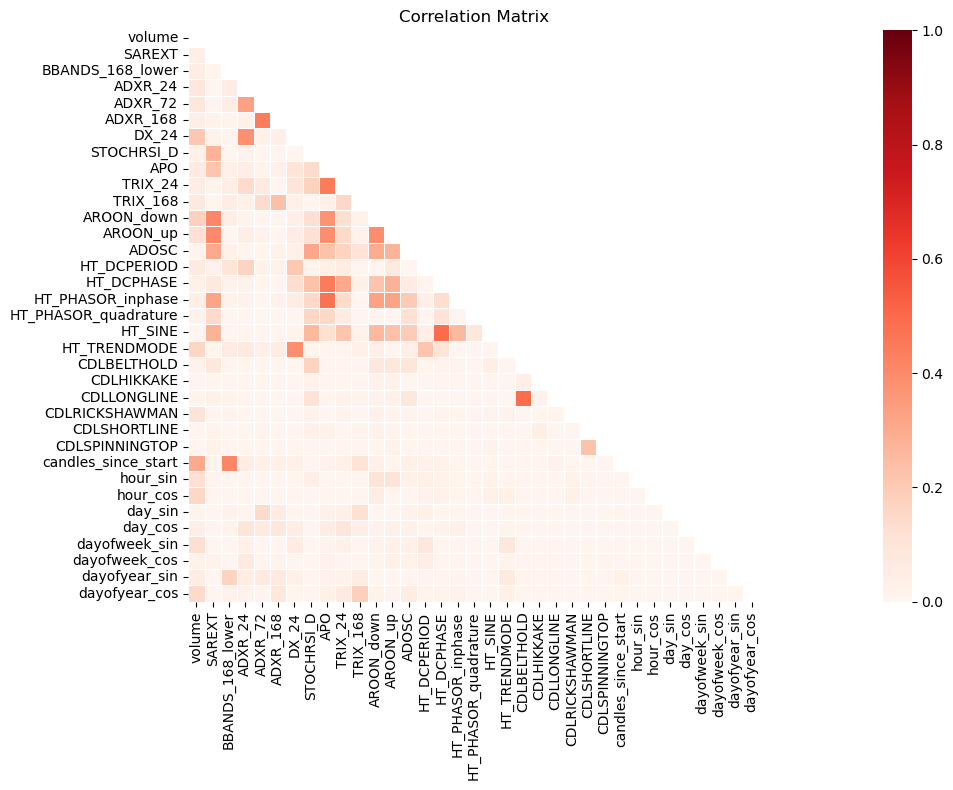

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,CDLSPINNINGTOP,candles_since_start,hour_sin,hour_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-08 17:00:00,0.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.0,-0.965926,-2.588190e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 18:00:00,0.000,-10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1.0,-1.000000,-1.836970e-16,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 19:00:00,471.659,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2.0,-0.965926,2.588190e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 20:00:00,583.271,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,3.0,-0.866025,5.000000e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
2019-09-08 21:00:00,689.759,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,4.0,-0.707107,7.071068e-01,0.998717,-0.050649,-0.781831,0.623490,-0.923158,-0.384421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,17158.018,24460.408648,18313.798495,18.303202,24.647746,14.036837,21.062621,77.822429,194.257051,0.030406,...,100,30846.0,-0.258819,9.659258e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946
2023-03-17 00:00:00,15107.275,24502.858129,18344.178781,17.991220,24.672446,14.091430,19.649624,77.234439,188.673077,0.031660,...,0,30847.0,0.000000,1.000000e+00,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376
2023-03-17 01:00:00,86181.415,24542.760641,18368.782631,18.029674,24.742696,14.156044,37.014849,83.236389,204.952564,0.034402,...,0,30848.0,0.258819,9.659258e-01,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376


In [43]:
uncorrelated_combined_features_df = filter_low_correlation_features(combined_features_df)
uncorrelated_combined_features_df

## **Handle missing values**

Due to the large number of records in our dataset, we can simply remove NaN values rather than imputing them with replacement methods.

In [44]:
def analyze_nan_distribution(df: pd.DataFrame):
    """
    Analyze the distribution of NaN values in time series data.
    Checks whether all NaN values are located in a single continuous block.
    
    Parameters:
        df (pd.DataFrame): DataFrame with time series data and features
    
    Returns:
        bool: True if all NaN values are consecutive, False if there are gaps
    """
    
    # Identify rows containing at least one NaN value
    nan_mask = df.isna().any(axis=1)
    nan_indices = df[nan_mask].index
    
    nan_count = nan_mask.sum()
    print(f"📊 Total rows with NaN values: {nan_count}")
    
    if nan_count == 0:
        print("✅ No NaN values found in the data.")
        return True
    
    # Check continuity: whether all NaN values are consecutive
    # This is done by examining the differences between indices
    nan_positions = df.index.get_indexer(nan_indices)  # Get positional indices
    diff = pd.Series(nan_positions).diff().dropna()
    
    # If all NaN values are consecutive, all differences should equal 1
    is_continuous = (diff == 1).all()
    
    if is_continuous:
        print("✅ All NaN values are located in a single continuous block.")
    else:
        print("❌ NaN values are distributed across multiple blocks (gaps detected).")
    
    # Position analysis
    first_nan = nan_indices[0]
    last_nan = nan_indices[-1]
    total_rows = len(df)
    first_pos = list(df.index).index(first_nan) / total_rows
    last_pos = list(df.index).index(last_nan) / total_rows
    
    print(f"First NaN occurrence: {first_nan}")
    print(f"Last NaN occurrence: {last_nan}")
    print(f"First NaN position: {first_pos:.1%} from start")
    print(f"Last NaN position: {last_pos:.1%} from start")
    
    return is_continuous

In [45]:
analyze_nan_distribution(uncorrelated_combined_features_df)

📊 Total rows with NaN values: 502
✅ All NaN values are located in a single continuous block.
First NaN occurrence: 2019-09-08 17:00:00
Last NaN occurrence: 2019-09-29 14:00:00
First NaN position: 0.0% from start
Last NaN position: 1.6% from start


np.True_

In [46]:
cleaned_uncorrelated_combined_features_df = uncorrelated_combined_features_df.dropna()
cleaned_uncorrelated_combined_features_df

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,CDLSPINNINGTOP,candles_since_start,hour_sin,hour_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-29 15:00:00,2242.376,-8214.621010,7174.474138,20.108274,37.856028,14.223433,32.975473,1.294001,-44.883333,-0.013695,...,-100,502.0,-0.707107,-7.071068e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 16:00:00,2212.549,-8188.569729,7173.043373,19.956190,37.952615,14.260393,25.617257,33.333333,-49.894295,-0.016079,...,0,503.0,-0.866025,-5.000000e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 17:00:00,1107.488,-8164.602551,7171.129905,19.769179,37.999773,14.299177,25.617257,55.098232,-57.573269,-0.018504,...,0,504.0,-0.965926,-2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 18:00:00,1020.505,-8142.552747,7169.158910,19.710498,38.051071,14.338617,28.458068,73.090582,-61.786282,-0.020992,...,-100,505.0,-1.000000,-1.836970e-16,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 19:00:00,1944.574,-8122.266927,7167.463197,19.661347,38.100646,14.377042,31.618446,51.534390,-65.164872,-0.023617,...,-100,506.0,-0.965926,2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,17158.018,24460.408648,18313.798495,18.303202,24.647746,14.036837,21.062621,77.822429,194.257051,0.030406,...,100,30846.0,-0.258819,9.659258e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946
2023-03-17 00:00:00,15107.275,24502.858129,18344.178781,17.991220,24.672446,14.091430,19.649624,77.234439,188.673077,0.031660,...,0,30847.0,0.000000,1.000000e+00,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376
2023-03-17 01:00:00,86181.415,24542.760641,18368.782631,18.029674,24.742696,14.156044,37.014849,83.236389,204.952564,0.034402,...,0,30848.0,0.258819,9.659258e-01,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376


## **Features Scaling and Encoding**

In [47]:
CATEGORICAL_COLUMNS = [col for col in cleaned_uncorrelated_combined_features_df.columns if col.startswith('CDL')]
CATEGORICAL_COLUMNS.append('HT_TRENDMODE')

SIN_COS_COLUMNS = [col for col in cleaned_uncorrelated_combined_features_df.columns if col.endswith('_sin') or col.endswith('_cos')]

def divide_columns(df: pd.DataFrame):

    numerical_df = df.copy()

    categorical_df = numerical_df[CATEGORICAL_COLUMNS].copy()
    numerical_df.drop(columns=CATEGORICAL_COLUMNS, inplace=True)

    sin_cos_df = numerical_df[SIN_COS_COLUMNS].copy()
    numerical_df.drop(columns=SIN_COS_COLUMNS, inplace=True)

    return numerical_df, categorical_df, sin_cos_df

In [48]:
train_numerical_df, train_categorical_df, train_sin_cos_df = divide_columns(cleaned_uncorrelated_combined_features_df)

In [49]:
LABEL_ENCODERS = {}

def fit_label_encoders(df: pd.DataFrame):

    for col in df.columns:
        le = LabelEncoder()
        le.fit(df[col].astype(str))
        LABEL_ENCODERS[col] = le

def transform_labels(df: pd.DataFrame):

    features_df = df.copy()

    for col in features_df.columns:
        le: LabelEncoder = LABEL_ENCODERS.get(col)
        features_df[col] = le.transform(features_df[col].astype(str))

    return features_df

In [50]:
fit_label_encoders(train_categorical_df)
train_cat_encoded_df = transform_labels(train_categorical_df)
train_cat_encoded_df

,CDLBELTHOLD,CDLHIKKAKE,CDLLONGLINE,CDLRICKSHAWMAN,CDLSHORTLINE,CDLSPINNINGTOP,HT_TRENDMODE
datetime,,,,,,,
2019-09-29 15:00:00,1,2,1,0,1,0,1
2019-09-29 16:00:00,1,2,1,0,1,1,1
2019-09-29 17:00:00,0,2,0,0,1,1,1
2019-09-29 18:00:00,1,3,1,0,0,0,1
2019-09-29 19:00:00,1,2,1,0,1,0,1
...,...,...,...,...,...,...,...
2023-03-16 23:00:00,1,0,1,1,2,2,1
2023-03-17 00:00:00,1,2,1,0,0,1,1
2023-03-17 01:00:00,2,2,1,0,1,1,1


### **Note: different types of scaling**

- **StandardScaler()**  
Transforms features to have mean = 0 and standard deviation = 1 (z-score normalization). Use when data follows a normal distribution and doesn't have outliers.

- **MinMaxScaler(feature_range=(0,1))**  
Scales features proportionally to fit within the [0,1] range. Use when data doesn't follow a normal distribution and doesn't have outliers.

- **RobustScaler()**  
Scales features using median and interquartile range. Use when data contains outliers.

In [51]:
scaler = RobustScaler()
train_num_scaled = scaler.fit_transform(train_numerical_df)

train_num_scaled_df = pd.DataFrame(
    train_num_scaled,
    columns=train_numerical_df.columns,
    index=train_numerical_df.index
)

### **Note: scaler and encoders**

Numerical features can be scaled using a single scaler because they represent continuous values that scalers are designed to handle effectively. In contrast, categorical features are discrete and may have varying numbers of unique values (e.g., 5 string categories vs. 3 numeric categories), so each categorical column typically requires individual encoder to properly map its unique values.

In [52]:
transformed_train_df = pd.concat([train_num_scaled_df, train_cat_encoded_df, train_sin_cos_df], axis=1)
transformed_train_df

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,CDLSPINNINGTOP,HT_TRENDMODE,hour_sin,hour_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-29 15:00:00,-0.658306,-0.346546,-0.462336,-0.124939,3.512950,0.899938,0.523148,-0.879569,-0.232243,-0.190074,...,0,1,-0.707107,-7.071068e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 16:00:00,-0.660630,-0.345946,-0.462387,-0.137929,3.527011,0.908001,0.218589,-0.313678,-0.256722,-0.216076,...,1,1,-0.866025,-5.000000e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 17:00:00,-0.746731,-0.345393,-0.462457,-0.153903,3.533877,0.916463,0.218589,0.070743,-0.294233,-0.242533,...,1,1,-0.965926,-2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 18:00:00,-0.753508,-0.344885,-0.462528,-0.158915,3.541345,0.925067,0.336171,0.388530,-0.314814,-0.269679,...,0,1,-1.000000,-1.836970e-16,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
2019-09-29 19:00:00,-0.681509,-0.344418,-0.462589,-0.163113,3.548563,0.933450,0.466980,0.007797,-0.331318,-0.298315,...,0,1,-0.965926,2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 23:00:00,0.503839,0.406352,-0.059041,-0.279120,1.590006,0.859231,0.030071,0.472106,0.935950,0.291036,...,2,1,-0.258819,9.659258e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946
2023-03-17 00:00:00,0.344056,0.407330,-0.057941,-0.305768,1.593602,0.871140,-0.028413,0.461721,0.908673,0.304720,...,1,1,0.000000,1.000000e+00,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376
2023-03-17 01:00:00,5.881766,0.408250,-0.057051,-0.302484,1.603829,0.885237,0.690339,0.567730,0.988197,0.334638,...,1,1,0.258819,9.659258e-01,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376


## **Create target variable for supervised learning tasks**

The model will be trained to predict the closing price for the next time period (next hour in this case, since we're working with 1-hour candlesticks). This involves shifting the closing price data by one period to create a supervised learning problem where each row contains the features for the current period and the target is the closing price of the subsequent period.

In [53]:
def create_target(df: pd.DataFrame, target: pd.Series) -> pd.DataFrame:
    """
    Combine feature DataFrame with target Series for supervised learning.
    The target represents the next candle's value (t+1 prediction).
    
    This function shifts the target series to create a supervised learning setup
    where each row contains features at time t and the target value at time t+1.
    It handles index alignment and removes rows with NaN values that result from
    the shifting operation.
    
    Args:
        df (pd.DataFrame): DataFrame containing feature variables
        target (pd.Series): Series containing target values (e.g., closing prices)
        
    Returns:
        pd.DataFrame: Combined DataFrame with features and target column
    """
    # Shift target by -1 to predict next value (t+1)
    shifted_target = target.shift(-1)

    # Find common indices between features and shifted target
    common_index = df.index.intersection(shifted_target.index)

    # Filter both datasets to common indices
    features_df = df.loc[common_index].copy()
    target_filtered = shifted_target.loc[common_index]

    # Remove rows with NaN values that appeared after shifting
    valid_index = target_filtered.dropna().index
    features_df = features_df.loc[valid_index]
    target_filtered = target_filtered.loc[valid_index]

    # Add target as a column to the features DataFrame
    features_df["target"] = target_filtered

    return features_df

In [54]:
train_dataset = create_target(df = transformed_train_df, target = train_target)
train_dataset

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,HT_TRENDMODE,hour_sin,hour_cos,day_sin,day_cos,dayofweek_sin,dayofweek_cos,dayofyear_sin,dayofyear_cos,target
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-29 15:00:00,-0.658306,-0.346546,-0.462336,-0.124939,3.512950,0.899938,0.523148,-0.879569,-0.232243,-0.190074,...,1,-0.707107,-7.071068e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324,8030.37
2019-09-29 16:00:00,-0.660630,-0.345946,-0.462387,-0.137929,3.527011,0.908001,0.218589,-0.313678,-0.256722,-0.216076,...,1,-0.866025,-5.000000e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324,7992.37
2019-09-29 17:00:00,-0.746731,-0.345393,-0.462457,-0.153903,3.533877,0.916463,0.218589,0.070743,-0.294233,-0.242533,...,1,-0.965926,-2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324,7979.04
2019-09-29 18:00:00,-0.753508,-0.344885,-0.462528,-0.158915,3.541345,0.925067,0.336171,0.388530,-0.314814,-0.269679,...,1,-1.000000,-1.836970e-16,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324,7956.40
2019-09-29 19:00:00,-0.681509,-0.344418,-0.462589,-0.163113,3.548563,0.933450,0.466980,0.007797,-0.331318,-0.298315,...,1,-0.965926,2.588190e-01,-0.394356,0.918958,-0.781831,0.623490,-0.999445,-0.033324,7988.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 22:00:00,0.346819,0.405311,-0.059926,-0.252510,1.587580,0.848089,-0.053801,-0.044386,0.973026,0.276827,...,1,-0.500000,8.660254e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946,24990.40
2023-03-16 23:00:00,0.503839,0.406352,-0.059041,-0.279120,1.590006,0.859231,0.030071,0.472106,0.935950,0.291036,...,1,-0.258819,9.659258e-01,-0.101168,-0.994869,0.433884,-0.900969,0.960885,0.276946,24904.60
2023-03-17 00:00:00,0.344056,0.407330,-0.057941,-0.305768,1.593602,0.871140,-0.028413,0.461721,0.908673,0.304720,...,1,0.000000,1.000000e+00,-0.299363,-0.954139,-0.433884,-0.900969,0.965507,0.260376,25654.40


## **Apply Recursive Feature Elimination (RFE) to select most informative features**

Initial model training attempts on the current dataset yielded poor performance, likely due to an excessive number of features with low predictive power. To address this, we will apply `Recursive Feature Elimination (RFE)` to identify and retain only the most informative features that have the strongest relationship with the target variable, thereby improving model performance and reducing overfitting risk.

In [55]:
X_data = train_dataset.drop(columns=["target"])
y_data = train_dataset["target"]

# RandomForestRegressor is chosen as the estimator for RFE because it provides 
# an excellent balance in classical machine learning between computational efficiency 
# and the ability to capture non-linear relationships in financial data
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rfe = RFE(estimator=model, n_features_to_select=20)

In [56]:
rfe.fit(X_data, y_data)

,estimator,RandomForestR...ndom_state=42)
,n_features_to_select,20
,step,1
,verbose,0
,importance_getter,'auto'
,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [57]:
selected_features = X_data.columns[rfe.support_]
ranking = pd.Series(rfe.ranking_, index=X_data.columns).sort_values()
selected_features

Index(['volume', 'SAREXT', 'BBANDS_168_lower', 'ADXR_24', 'ADXR_72',
       'ADXR_168', 'DX_24', 'STOCHRSI_D', 'APO', 'TRIX_24', 'TRIX_168',
       'ADOSC', 'HT_DCPERIOD', 'HT_PHASOR_inphase', 'candles_since_start',
       'day_sin', 'day_cos', 'dayofweek_sin', 'dayofyear_sin',
       'dayofyear_cos'],
      dtype='object')

In [58]:
ranking

volume                   1
SAREXT                   1
BBANDS_168_lower         1
ADXR_24                  1
ADXR_72                  1
ADXR_168                 1
DX_24                    1
STOCHRSI_D               1
APO                      1
TRIX_24                  1
TRIX_168                 1
ADOSC                    1
HT_DCPERIOD              1
dayofweek_sin            1
candles_since_start      1
HT_PHASOR_inphase        1
day_sin                  1
day_cos                  1
dayofyear_cos            1
dayofyear_sin            1
HT_DCPHASE               2
HT_PHASOR_quadrature     3
HT_SINE                  4
AROON_up                 5
AROON_down               6
dayofweek_cos            7
hour_sin                 8
hour_cos                 9
CDLLONGLINE             10
HT_TRENDMODE            11
CDLBELTHOLD             12
CDLSPINNINGTOP          13
CDLHIKKAKE              14
CDLSHORTLINE            15
CDLRICKSHAWMAN          16
dtype: int64

In [59]:
filtered_train_dataset = train_dataset[selected_features.tolist() + ['target']]
filtered_train_dataset

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,ADOSC,HT_DCPERIOD,HT_PHASOR_inphase,candles_since_start,day_sin,day_cos,dayofweek_sin,dayofyear_sin,dayofyear_cos,target
datetime,,,,,,,,,,,,,,,,,,,,,
2019-09-29 15:00:00,-0.658306,-0.346546,-0.462336,-0.124939,3.512950,0.899938,0.523148,-0.879569,-0.232243,-0.190074,...,-0.141437,-0.598128,-0.091463,-1.000000,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,8030.37
2019-09-29 16:00:00,-0.660630,-0.345946,-0.462387,-0.137929,3.527011,0.908001,0.218589,-0.313678,-0.256722,-0.216076,...,-0.033029,-0.501344,-0.148179,-0.999934,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7992.37
2019-09-29 17:00:00,-0.746731,-0.345393,-0.462457,-0.153903,3.533877,0.916463,0.218589,0.070743,-0.294233,-0.242533,...,-0.020802,-0.332337,-0.338037,-0.999868,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7979.04
2019-09-29 18:00:00,-0.753508,-0.344885,-0.462528,-0.158915,3.541345,0.925067,0.336171,0.388530,-0.314814,-0.269679,...,-0.032233,-0.104525,-0.479410,-0.999802,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7956.40
2019-09-29 19:00:00,-0.681509,-0.344418,-0.462589,-0.163113,3.548563,0.933450,0.466980,0.007797,-0.331318,-0.298315,...,-0.059596,0.174145,-0.406518,-0.999736,-0.394356,0.918958,-0.781831,-0.999445,-0.033324,7988.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-16 22:00:00,0.346819,0.405311,-0.059926,-0.252510,1.587580,0.848089,-0.053801,-0.044386,0.973026,0.276827,...,0.590154,0.289365,-0.558910,0.999670,-0.101168,-0.994869,0.433884,0.960885,0.276946,24990.40
2023-03-16 23:00:00,0.503839,0.406352,-0.059041,-0.279120,1.590006,0.859231,0.030071,0.472106,0.935950,0.291036,...,0.657140,0.313627,-0.537790,0.999736,-0.101168,-0.994869,0.433884,0.960885,0.276946,24904.60
2023-03-17 00:00:00,0.344056,0.407330,-0.057941,-0.305768,1.593602,0.871140,-0.028413,0.461721,0.908673,0.304720,...,0.303549,0.366213,0.419432,0.999802,-0.299363,-0.954139,-0.433884,0.965507,0.260376,25654.40


## **Save processed train dataset for model training**

In [60]:
filtered_train_dataset.to_parquet("../data/processed/train_dataset.parquet")

## **Process test dataset**

In this section, we apply the same preprocessing steps to the test dataset that were used on the training dataset to ensure consistency.

In [61]:
OPEN_PRICES_TEST = test_df['open'].values
HIGH_PRICES_TEST = test_df['high'].values
LOW_PRICES_TEST = test_df['low'].values
CLOSE_PRICES_TEST = test_df['close'].values
VOLUME_TEST = test_df['volume'].astype(np.double).values

test_target = test_df.pop('close')

In [62]:
def align_features_to_train(train_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
    """
    Align test DataFrame features to match training DataFrame features.
    
    Args:
        train_df (pd.DataFrame): Training dataset containing the reference features
        test_df (pd.DataFrame): Test dataset that needs feature alignment
        
    Returns:
        pd.DataFrame: Test dataset containing only features present in training data
    """
    # Find intersection of columns between training and test datasets
    common_columns = train_df.columns.intersection(test_df.columns)
    
    # Return test DataFrame with only the common features
    return test_df[common_columns]

In [63]:
test_indicators_df = create_moving_averages_indicator_group(df = test_df, close_prices = CLOSE_PRICES_TEST)

test_indicators_df = create_overlap_studies_indicator_group(
    df = test_indicators_df, 
    close_prices=CLOSE_PRICES_TEST, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST
)

test_indicators_df = create_momentum_index_indicator_group(
    df = test_indicators_df, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST,
    volume=VOLUME_TEST
)

test_indicators_df = create_oscillator_indicator_group(
    df = test_indicators_df,
    open_prices=OPEN_PRICES_TEST,
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST
)

test_indicators_df = create_momentum_indicators_indicator_group(
    df = test_indicators_df, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST
)

test_indicators_df = create_volume_cycle_indicator_group(
    df = test_indicators_df, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST, 
    volume=VOLUME_TEST
)

test_indicators_df = create_price_volatility_indicator_group(
    df = test_indicators_df, 
    open_prices=OPEN_PRICES_TEST, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST
)

test_indicators_df = create_pattern_recognition_indicator_group(
    df = test_indicators_df,
    open_prices=OPEN_PRICES_TEST, 
    high_prices=HIGH_PRICES_TEST, 
    low_prices=LOW_PRICES_TEST, 
    close_prices=CLOSE_PRICES_TEST
)

test_indicators_df = create_time_recognition_indicator_group(test_indicators_df)

In [64]:
aligned_test_indicators_df = align_features_to_train(transformed_train_df, test_indicators_df)
cleaned_aligned_test_indicators_df = aligned_test_indicators_df.dropna()

test_numerical_df, test_categorical_df, test_sin_cos_df = divide_columns(cleaned_aligned_test_indicators_df)
test_cat_encoded_df = transform_labels(test_categorical_df)
test_num_scaled = scaler.transform(test_numerical_df)

test_num_scaled_df = pd.DataFrame(
    test_num_scaled,
    columns=test_numerical_df.columns,
    index=test_numerical_df.index
    )

transformed_test_df = pd.concat([test_num_scaled_df, test_cat_encoded_df, test_sin_cos_df], axis=1)
test_dataset = create_target(df = transformed_test_df, target = test_target)

filtered_test_dataset = align_features_to_train(filtered_train_dataset, test_dataset)
filtered_test_dataset

,volume,SAREXT,BBANDS_168_lower,ADXR_24,ADXR_72,ADXR_168,DX_24,STOCHRSI_D,APO,TRIX_24,...,ADOSC,HT_DCPERIOD,HT_PHASOR_inphase,candles_since_start,day_sin,day_cos,dayofweek_sin,dayofyear_sin,dayofyear_cos,target
datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-07 02:00:00,-0.039581,0.482888,0.279974,-1.029094,-1.047185,-1.528351,-0.517167,0.023979,0.118588,-0.250269,...,0.057101,-0.536688,-0.194479,-1.000000,0.988468,0.151428,-0.433884,0.995218,-0.097683,28022.2
2023-04-07 03:00:00,-0.432890,0.483069,0.279926,-1.045679,-1.047088,-1.529078,-0.517167,-0.402053,0.100003,-0.245009,...,0.196356,-0.560025,0.030443,-0.999934,0.988468,0.151428,-0.433884,0.995218,-0.097683,28009.9
2023-04-07 04:00:00,-0.425983,0.483247,0.279869,-1.058840,-1.048221,-1.530268,-0.553689,-0.664539,0.086379,-0.239467,...,0.180107,-0.587216,0.170781,-0.999868,0.988468,0.151428,-0.433884,0.995218,-0.097683,27963.6
2023-04-07 05:00:00,0.107595,0.483421,0.279836,-1.057547,-1.050431,-1.531064,-0.230227,-0.664539,0.089181,-0.234624,...,0.352048,-0.616754,0.351570,-0.999802,0.988468,0.151428,-0.433884,0.995218,-0.097683,27950.1
2023-04-07 06:00:00,-0.155566,0.483591,0.279778,-1.046108,-1.052610,-1.533680,-0.230227,-0.827254,0.108687,-0.230583,...,0.552086,-0.645849,0.311368,-0.999736,0.988468,0.151428,-0.433884,0.995218,-0.097683,27822.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01 07:00:00,-0.389572,-1.144408,0.722618,-0.000746,0.096430,0.488974,0.247180,0.855711,-1.943151,-0.287135,...,-0.286259,-1.049670,-2.253338,-0.525175,0.201299,0.979530,0.433884,0.523094,0.852275,42236.0
2024-02-01 08:00:00,-0.471922,-1.142612,0.723883,-0.012806,0.083294,0.484223,0.247180,0.855711,-1.928772,-0.321869,...,-0.078549,-1.018815,-1.556675,-0.525109,0.201299,0.979530,0.433884,0.523094,0.852275,42141.0
2024-02-01 09:00:00,-0.484898,-1.140960,0.725198,-0.010933,0.070684,0.479634,0.223659,0.394069,-1.896512,-0.354583,...,-0.107634,-0.960194,-1.102577,-0.525043,0.201299,0.979530,0.433884,0.523094,0.852275,42214.1


## **Save processed test dataset for model evaluation**

In [65]:
filtered_test_dataset.to_parquet("../data/processed/test_dataset.parquet")